How well do our observations at 0.33$R_{26}$ match MaNGA's DR17 observations at the same radius?  And how well do our velocities observed at these radii reproduce the asymptotic rotational velocity?

In [1]:
import numpy as np
import numpy.ma as ma

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u
from astropy import wcs

import scipy.stats as stats
from scipy.optimize import minimize, curve_fit

import numdifftools as ndt

# from hyperfit.linfit import LinFit

import corner

import os

# Path to RotationCurve libraries. Update as needed.
# rotcurvepath = os.path.join(os.environ['HOME'], 'desi/RotationCurves/spirals')
rotcurvepath = os.path.join(os.environ['HOME'], 'RotationCurves/spirals')
# rotcurvepath = os.path.join(os.environ['HOME'], 'Documents/Research/Rotation_curves/RotationCurves/spirals')
if not os.path.exists(rotcurvepath):
    raise FileNotFoundError(f'{rotcurvepath} does not exist.')

import sys
sys.path.insert(1, rotcurvepath)
from dark_matter_mass_v1 import rot_fit_BB

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.lines as mlines

In [2]:
mpl.rc('font', size=12)

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
h = 1
H0 = 100*h*u.km/u.s/u.Mpc

c = const.c.to('km/s')

q0 = 0.2

MANGA_SPAXEL_SIZE = 0.5*u.arcsec

# Redrock systematic duplicate redshift uncertainty (from Lan+23)
dv_sys = 7 # km/s

# Import data

## DESI

In [4]:
tf_targets = Table.read('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_fuji_healpix.fits')
# tf_targets = Table.read('/Users/kdouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')

## SGA

In [5]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
# SGA = Table.read('/Users/kdouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')

In [6]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## SDSS MaNGA cross-match file

In [7]:
SGA_MaNGA = Table.read('../MaNGA_SGA_crossmatch_2022-06-28.txt', format='ascii.commented_header')

SGA_MaNGA[:5]

plate,ifudsgn,plateifu,SGA_ID
int64,int64,str11,int64
8716,3703,8716-3703,927743
9086,6104,9086-6104,1003700
11967,1902,11967-1902,196166
8613,6104,8613-6104,376271
10001,3703,10001-3703,937846


## SDSS MaNGA best-fits

Nitya's fitting from 2023 on DR17

In [80]:

MaNGA_fits = Table.read(#'master_table_Halpha_BB_HI_H2_MxCG_R90_CMD.txt', 
                        'master_table_Halpha_BB_HI_H2_MxCG_R90_CMD_ZPG16R_SFR_MZ.txt', 
                        format='ascii.commented_header')
'''
MaNGA_fits = Table.read('H_alpha_HIvel_BB_refit_ba.fits')
# MaNGA_fits = Table.read('/Users/kdouglass/Documents/Research/Rotation_curves/Nitya_Ravi/H_alpha_HIvel_BB_refit_ba.fits')
'''
MaNGA_fits[:5]

MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_ID,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,smoothness_score,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,M3p5_map,M3p5_err_map,rho_bulge_map,rho_bulge_err_map,R_bulge_map,R_bulge_err_map,M90_disk_map,M90_disk_err_map,M3p5_disk_map,M3p5_disk_err_map,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,logHI200kms,WF50,WF50_err,map_fit_flag,DL_ttype,rabsmag_NSA,R90_kpc,MaNGA_sample,CMD_class,v_3p5,v_3p5_err,logH2_M,logH2_CG,logH2_CG_err,M_Z,M_Z_err,Rmax,SFR,sSFR,SFR_err,sSFR_err,Z_PG16R_map,Z_PG16R_err_map,M_Z_map,M_Z_err_map,Z_PG16R,Z_PG16R_err,index,imc,aimc,cd,u_r_KIAS
int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
10001,12701,448,450,51900,48157,51226,133.3710906116639,57.59842514455842,0.417013,69.2463,0.0392074,2685340000.0,1.560186343059074,0.8525269160441389,0.004661246847300842,61.88507825188626,0.07338042747869138,2.946989472970758,0.09848277794062997,38.7739389484797,0.022936739976051144,37.440940071078124,0.016138461970098106,183.15428191832711,2.8318738759310786,4.181226771589277,0.07058094055808059,2.2299464843830368,0.006099342053787376,10.637055736445056,9.856536145016422,11.185428134112588,10.663096428880776,318528356.25649077,10973819.90888883,1.1700697820493802,0.01234311518755433,10.054323200255043,8.681101900065409,10.119328135890797,8.780959524997495,9.852487564086914,10.529260284502032,10.529260284502032,10.350040435791016,-999.0,309.752973573684,50.84180796596384,1.5,6.564641952514648,-19.2112,5.614479609229095,2.0,1.0,183.14938552312165,24.91258446340628,-999.0,-999.0,-999.0,8.486220534884033,7.883433825112772,6.435441132989916,-0.02367674559354782,-9.747639656066895,0.5330458879470825,0.5682201385498047,0.0,0.0,0.0,0.0,8.421086766593023,0.036466659990572275,234303,2.0,68.98,-0.115,1.53
10001,12702,448,524,51900,48188,51261,133.68566986867248,57.48025032183927,0.598115,12.5169,0.0408108,4642460000.0,1.5619979358006435,0.6739844282455619,0.006739656007202572,188.3088174477578,0.16826186470866497,0.6765359119793715,0.23419562301556418,36.85326879733403,0.04204024887591865,37.98221005537202,0.05640746039294769,194.97775272347383,6.932242299930594,0.6629820156636723,0.04575759010348131,0.9585752877878831,0.07208969706038451,10.600037009816079,10.15080355502181,11.292909462167833,10.847252340042417,115971867.9868961,7747575.084882941,1.6956282295929506,0.03670610210595715,10.124313484194262,9.034999166941406,10.177811159857796,9.124034282826187,14.355437278747559,2.457986344552885,2.457986344552885,9.583724021911621,-999.0,273.50491644321835,6.866128229994085,3.5,4.730921268463135,-19.0722,8.515048082090281,2.0,2.0,168.30899596736322,29.53675151629983,-999.0,-999.0,-999.0,0.0,0.0,10.492041769351301,-0.5348737239837646,-10.398966789245605,0.8455471992492676,0.8668661117553711,0.0,0.0,0.0,0.0,0.0,0.0,1093626,2.0,23.79,-0.093,2.149
10001,12703,483,535,51924,55648,59078,136.01715996919202,57.09232917791099,0.378034,51.5052,0.0462094,9439710000.0,1.1414035570714935,0.868911357820688,0.0007131052643978732,56.79483322166177,0.08249999450764357,16.699456893928602,0.0963277859001372,36.558508375391675,0.020946818786307338,35.641571170832165,0.018071593708941423,369.9104377816068,1.1162754236338,1.0019694161891133,0.003716146716676395,2.2255004811754473,0.0259

# Calculate the rotational velocities for the DESI galaxies

## Separate the fuji data into center and off-center observations

In [9]:
tf_targets['SKY_FIBER_DIST'] = 0.
tf_targets['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tf_targets['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tf_targets['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tf_targets['RA'][obs_idx], 
                             dec=tf_targets['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tf_targets['SKY_FIBER_DIST'][obs_idx] = sep2d
    tf_targets['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

In [10]:
centers_boolean = tf_targets['SKY_FIBER_DIST_R26'] < 0.1

centers = tf_targets[centers_boolean]
axis = tf_targets[~centers_boolean]

## Clean the fuji center observations

Only keep those with
* `DELTACHI2` > 25
* `ZWARN` == 0

In [11]:
good_centers = centers[(centers['DELTACHI2'] > 25) & (centers['ZWARN'] == 0)]

## If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [12]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

In [13]:
SGA_MaNGA['Z_DESI'] = np.nan
SGA_MaNGA['ZERR_DESI'] = np.nan
SGA_MaNGA['R26'] = np.nan
SGA_MaNGA['BA'] = np.nan
SGA_MaNGA['PA'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[SGA_MaNGA['SGA_ID'][i]]
    
    # Set the redshift of this galaxy
    SGA_MaNGA['Z_DESI'][i] = SGA['Z_DESI'][SGA_idx]
    SGA_MaNGA['ZERR_DESI'][i] = SGA['ZERR_DESI'][SGA_idx]
    
    # Transfer R26 over to the SGA_MaNGA table
    SGA_MaNGA['R26'][i] = 0.5*SGA['D26'][SGA_idx]
    
    # Transfer b/a over to the SGA_MaNGA table
    SGA_MaNGA['BA'][i] = SGA['BA'][SGA_idx]
    
    # Transfer phi over to the SGA_MaNGA table
    SGA_MaNGA['PA'][i] = SGA['PA'][SGA_idx]

## Calculate the rotational velocity

In [14]:
axis['SKY_FIBER_DIST'] = 0.
axis['SKY_FIBER_DIST_R26'] = 0.
axis['V_ROT'] = np.nan
axis['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis['RA'][obs_idx], 
                             dec=axis['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis['SKY_FIBER_DIST'][obs_idx] = sep2d.to('radian')
    axis['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    # axis['V_ROT'][obs_idx] = c*(axis['Z'][obs_idx] - z_center)
    # axis['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis['ZERR'][obs_idx]**2 + z_err_center2)
    z_rot = (1 + axis['Z'][obs_idx])/(1 + z_center) - 1
    axis['V_ROT'][obs_idx] = c*z_rot
    axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((axis['ZERR'][obs_idx]/(1 + z_center))**2 + z_err_center2*((1 + axis['Z'][obs_idx])/(1 + z_center)**2) + (dv_sys/c).value**2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

## Just keep those velocities measured at $0.33R_{26}$

In [15]:
axis_0p3 = axis[(axis['SKY_FIBER_DIST_R26'] > 0.3) & (axis['SKY_FIBER_DIST_R26'] < 0.4)]

## Remove "bad" galaxies

Those with
* $10 > V > 1000$ km/s
* $\Delta V / V_{min} < 5$
* $i < 25^\circ$

In [16]:
axis_0p3_goodV = axis_0p3[(np.abs(axis_0p3['V_ROT']) < 1000) & (np.abs(axis_0p3['V_ROT']) > 10)]

In [17]:
good_deltaV = np.ones(len(axis_0p3_goodV), dtype=bool)

for sga_id in np.unique(axis_0p3_goodV['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_0p3_goodV['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(axis_0p3_goodV['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(axis_0p3_goodV['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(axis_0p3_goodV['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(axis_0p3_goodV['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(axis_0p3_goodV['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(axis_0p3_goodV['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            '''
            print(sga_id)
            print(diff_matrix_norm)
            print(1/v_norm_min.data)
            print(v_norm_max.data)
            print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
            ''';
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = axis_0p3_goodV['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(axis_0p3_goodV['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(axis_0p3_goodV['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(axis_0p3_goodV['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    '''
                    print(sga_id)
                    print(diff_matrix_norm)
                    print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
                    ''';
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False
                    
axis_0p3_good = axis_0p3_goodV[good_deltaV]

## Also remove those that have been visually inspected to be suspicious

In [18]:
VI_remove = Table.read('../../TF/SV/fuji_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(axis_0p3_good), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (axis_0p3_good['TARGETID'] == targetid)
    
VI_axis_0p3_good = axis_0p3_good[~remove_targets]

print(len(VI_axis_0p3_good), len(np.unique(VI_axis_0p3_good['SGA_ID'])))

2306 1195


## Add the rotational velocities to the SDSS MaNGA - SGA cross-match file

In [19]:
SGA_MaNGA['V_0p33R26'] = np.nan
SGA_MaNGA['V_0p33R26_ERR'] = np.nan

SGA_MaNGA['SKY_FIBER_DIST'] = np.nan

weights = 1./(VI_axis_0p3_good['V_ROT_ERR']**2)

for i in range(len(SGA_MaNGA)):
    
    # Does this galaxy have any observations?
    i_obs = VI_axis_0p3_good['SGA_ID'] == SGA_MaNGA['SGA_ID'][i]
    
    if np.sum(i_obs) > 0:
        
        # Average all velocities at this radius
        SGA_MaNGA['V_0p33R26'][i] = np.average(np.abs(VI_axis_0p3_good['V_ROT'][i_obs]), 
                                               weights=weights[i_obs])
        SGA_MaNGA['V_0p33R26_ERR'][i] = np.sqrt(1./np.sum(weights[i_obs]))
        
        # Copy over the distance from the center for this observation
        SGA_MaNGA['SKY_FIBER_DIST'][i] = np.average(VI_axis_0p3_good['SKY_FIBER_DIST'][i_obs])

In [20]:
SGA_MaNGA[np.isfinite(SGA_MaNGA['V_0p33R26'])].show_in_notebook()

idx,plate,ifudsgn,plateifu,SGA_ID,Z_DESI,ZERR_DESI,R26,BA,PA,V_0p33R26,V_0p33R26_ERR,SKY_FIBER_DIST
0,9874,6104,9874-6104,1203610,0.023598087730187,1.84622497331648e-05,0.3885289430618286,0.4241816997528076,115.80484008789062,62.353740980054454,20.98220237842247,3.72961035942818e-05
1,8979,12703,8979-12703,544943,0.0388599155970507,8.79615833223146e-06,0.29538485407829285,0.6018548011779785,135.25755310058594,92.75090949227058,9.595381235844085,2.8354910339964662e-05
2,8555,9102,8555-9102,1285122,0.0459386508726562,1.07265977632736e-05,0.2687503695487976,0.7685890793800354,107.45079040527344,152.41078276247794,5.586597613898804,2.5798182956148833e-05
3,8932,6102,8932-6102,1379275,0.0202592517081387,4.16721334032235e-05,0.34102562069892883,0.40062516927719116,5.078217506408691,82.67351508481578,31.465424704162576,3.273610867358773e-05
4,9031,12702,9031-12702,1205063,0.0403143764659635,1.79474559121421e-05,0.2188577502965927,0.9376584887504578,28.06189727783203,25.124650650360024,5.172646371403204,2.1008836134171055e-05
5,8950,9102,8950-9102,1294562,0.0233125050298342,1.63355952707834e-05,0.446351021528244,0.7503887414932251,139.5088348388672,107.75370339006517,16.802289002780086,4.284662157514828e-05
6,10516,3704,10516-3704,650204,0.0220643903686963,1.4325574828983e-05,0.6425082087516785,0.5286684632301331,137.71206665039062,182.22869203870746,10.85106587117253,6.167635881356584e-05
7,8932,12702,8932-12702,100987,0.020498886671880285,4.469284813930325e-06,0.8002187013626099,0.22466039657592773,114.50669860839844,116.99387696841006,13.013077328468842,7.681547834141546e-05
8,9862,12704,9862-12704,1349168,0.0210489811714899,2.15219041813757e-05,0.20946325361728668,0.8806456923484802,60.43546676635742,40.753682571257706,25.46146591695096,2.0107029171966626e-05
9,9031,12705,9031-12705,1287210,0.0596930483603828,1.82005218873652e-05,0.2627129852771759,0.8110915422439575,21.210365295410156,160.81459403658556,5.223822763442569,2.5218636168164603e-05


**These need to be double-checked!**

Based on visual inspection of Nitya's fits to the MaNGA DR17 data for these galaxies, I determined that
* Galaxies that need to be refit: 8949-12703, 8950-12705, 9037-9102, 9877-3702, 10845-6101, 11009-1902, 11009-3703, 11939-3701, 11949-12702
* Galaxies that are not spirals but have fits: 
* Galaxies that do not have fits (either no data or are not spirals): 8321-6103, 8931-1902, 8931-3702, 8932-3703, 8932-6102, 8932-12702, 8932-12705, 8935-9101, 8949-9102, 8949-12705, 8950-3702, 8950-9102, 8950-12702, 8951-3704, 8951-12704, 9862-3701, 9862-12704, 9874-6104, 9876-6102, 9877-3703, 9877-3704, 11006-3704, 11006-6104, 11006-12701, 11007-9101, 11014-3702, 11014-12703, 11015-1901, 11939-3702, 11939-12703

## Add the MaNGA best-fit values to the table

In [82]:
SGA_MaNGA['Vmax_map'] = np.nan
SGA_MaNGA['Vmax_err_map'] = np.nan
SGA_MaNGA['Rturn_map'] = np.nan
SGA_MaNGA['alpha_map'] = np.nan

SGA_MaNGA['ba_map'] = np.nan
SGA_MaNGA['ba_err_map'] = np.nan
SGA_MaNGA['ba_NSA'] = np.nan

SGA_MaNGA['phi_map'] = np.nan
SGA_MaNGA['phi_err_map'] = np.nan
SGA_MaNGA['phi_NSA'] = np.nan

SGA_MaNGA['Z_NSA'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    gal_id = SGA_MaNGA['plateifu'][i]
    
    # Find galaxy row in MaNGA fits table
    
    plate_bool = MaNGA_fits['MaNGA_plate'] == SGA_MaNGA['plate'][i]
    ifu_bool = MaNGA_fits['MaNGA_IFU'] == SGA_MaNGA['ifudsgn'][i]
    
    i_fit = plate_bool & ifu_bool
    '''
    i_fit = MaNGA_fits['plateifu'] == SGA_MaNGA['plateifu'][i]
    '''
    # Copy best-fit parameter values from fit table to galaxy table
    if (np.sum(i_fit) > 0): #and (gal_id not in []):
        
        SGA_MaNGA['Vmax_map'][i] = MaNGA_fits['Vmax_map'][i_fit]
        SGA_MaNGA['Vmax_err_map'][i] = MaNGA_fits['Vmax_err_map'][i_fit]
        SGA_MaNGA['Rturn_map'][i] = MaNGA_fits['Rturn_map'][i_fit]
        SGA_MaNGA['alpha_map'][i] = MaNGA_fits['alpha_map'][i_fit]
        
        SGA_MaNGA['ba_map'][i] = MaNGA_fits['ba_map'][i_fit]
        SGA_MaNGA['ba_err_map'][i] = MaNGA_fits['ba_err_map'][i_fit]
        SGA_MaNGA['ba_NSA'][i] = MaNGA_fits['NSA_ba'][i_fit]
        
        SGA_MaNGA['phi_map'][i] = MaNGA_fits['phi_map'][i_fit]
        SGA_MaNGA['phi_err_map'][i] = MaNGA_fits['phi_err_map'][i_fit]
        SGA_MaNGA['phi_NSA'][i] = MaNGA_fits['NSA_phi'][i_fit]
        
        SGA_MaNGA['Z_NSA'][i] = MaNGA_fits['NSA_redshift'][i_fit]
        '''
        SGA_MaNGA['Vmax_map'][i] = MaNGA_fits['v_max'][i_fit]
        SGA_MaNGA['Vmax_err_map'][i] = MaNGA_fits['v_max_err'][i_fit]
        SGA_MaNGA['Rturn_map'][i] = MaNGA_fits['r_turn'][i_fit]
        SGA_MaNGA['alpha_map'][i] = MaNGA_fits['alpha'][i_fit]
        
        SGA_MaNGA['ba_map'][i] = MaNGA_fits['ba'][i_fit]
        SGA_MaNGA['ba_err_map'][i] = MaNGA_fits['ba_err'][i_fit]
        SGA_MaNGA['ba_NSA'][i] = MaNGA_fits['nsa_elpetro_ba'][i_fit]
        
        SGA_MaNGA['phi_map'][i] = MaNGA_fits['phi'][i_fit]
        SGA_MaNGA['phi_err_map'][i] = MaNGA_fits['phi_err'][i_fit]
        SGA_MaNGA['phi_NSA'][i] = MaNGA_fits['nsa_elpetro_phi'][i_fit]
        
        SGA_MaNGA['Z_NSA'][i] = MaNGA_fits['nsa_z'][i_fit]
        '''

# Flip all -99 values to NaN
for col_name in SGA_MaNGA.colnames:
    
    bad_values = SGA_MaNGA[col_name] == -999
    
    if np.any(bad_values):
        SGA_MaNGA[col_name][bad_values] = np.nan

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/astropy/table/column.py:351: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)


In [83]:
good_V = np.isfinite(SGA_MaNGA['Vmax_map']) & np.isfinite(SGA_MaNGA['V_0p33R26'])

print(np.sum(good_V))

69


In [84]:
# Also remove those galaxies from the final sample that have V(R26) < 0.9Vmax, and have Vmax > 1000 km/s

# 1 - Convert R26 to kpc for each galaxy
dist_to_galaxy = SGA_MaNGA['Z_DESI']*c/H0
R26_kpc = dist_to_galaxy.to('kpc')*np.tan((SGA_MaNGA['R26']*u.arcmin).to(u.rad))

# 2 - Compute V(R26)
SGA_MaNGA['Vfit_R26'] = rot_fit_BB(R26_kpc.data, [SGA_MaNGA['Vmax_map'], SGA_MaNGA['Rturn_map'], SGA_MaNGA['alpha_map']])

# 3 - Filter out those with V(R26) < 0.9Vmax
goodVmax = SGA_MaNGA['Vfit_R26'] >= 0.9*SGA_MaNGA['Vmax_map']

# 4 - Filter out those with Vmax > 1000 km/s
lowVmax = SGA_MaNGA['Vmax_map'] < 1000.
'''
# 5 - Filter out those with alpha > 99
good_alpha = SGA_MaNGA['alpha_map'] < 99.

# 6 - Filter out those with large uncertainties in Vmax
goodVmax2 = SGA_MaNGA['Vmax_err_map']/SGA_MaNGA['Vmax_map'] <= 2
''';

# #7 - Filter out those with i_SGA < 25 (requirement of TF sample)
cosi2 = (SGA_MaNGA['BA']**2 - q0**2)/(1 - q0**2)
cosi2[cosi2 < 0] = 0
cosi2_max = np.cos(25*np.pi/180)**2
goodi = cosi2 <= cosi2_max

final_sample = good_V & goodVmax & lowVmax & goodi #& good_alpha & goodVmax2

In [85]:
SGA_MaNGA[final_sample]
#SGA_MaNGA[good_V & ~goodVmax]

plate,ifudsgn,plateifu,SGA_ID,Z_DESI,ZERR_DESI,R26,BA,PA,V_0p33R26,V_0p33R26_ERR,SKY_FIBER_DIST,Vmax_map,Vmax_err_map,Rturn_map,alpha_map,ba_map,ba_err_map,ba_NSA,phi_map,phi_err_map,phi_NSA,Z_NSA,Vfit_R26,Vfit_0p33R26,Vfit_0p4R26,delta_phi,Vfit_0p33R26_err,Vfit_corr_0p33R26,Vfit_corr_0p33R26_err,i_map
int64,int64,str11,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8555,9102,8555-9102,1285122,0.0459386508726562,1.07265977632736e-05,0.2687503695487976,0.7685890793800354,107.45079040527344,152.41078276247794,5.586597613898804,2.5798182956148833e-05,233.83042783736894,1.021909715794632,1.4070703936724118,1.6922192094379271,0.8805768500939793,0.0011076494541208907,0.792966,113.54882003432462,0.06053489464548014,118.876,0.0459673,229.5246211811809,224.52048767450515,234.44353398904843,3.839941716777119,2.97552665926588,154.08096159258233,1.6698313568258463,0.4657529299679008
10516,3704,10516-3704,650204,0.0220643903686963,1.4325574828983e-05,0.6425082087516785,0.5286684632301331,137.71206665039062,182.22869203870746,10.85106587117253,6.167635881356584e-05,167.92036947486488,0.5435591335525691,2.376914723623752,24.620661980049764,0.6357762278631116,0.005093881801921856,0.80091,315.5424899389288,0.09509435952358725,125.383,0.0220177,167.92036947486488,189.95211558090526,193.58332347030986,1.1733507326748054,31.253525990138176,174.312786851195,28.409613050161035,0.919289341802592
9031,12705,9031-12705,1287210,0.0596930483603828,1.82005218873652e-05,0.2627129852771759,0.8110915422439575,21.210365295410156,160.81459403658556,5.223822763442569,2.5218636168164603e-05,302.11461048641087,6.863456675184224,1.6116837507353448,1.3491939701088254,0.8930755890717574,0.004790151135259776,0.838519,21.708667556923782,0.06282828957213252,51.9734,0.0598426,290.1866695821718,256.3053706393556,265.4363094085194,0.4985125754505191,6.2241984352311475,197.03031119439603,1.0089673751897827,0.4767971853542582
9036,6101,9036-6101,1287210,0.0596930483603828,1.82005218873652e-05,0.2627129852771759,0.8110915422439575,21.210365295410156,160.81459403658556,5.223822763442569,2.5218636168164603e-05,237.29434316799617,2.6996033257878556,1.6869715762972526,1.3749944406284882,0.812447889415118,0.003110362836085583,0.838519,21.37675160089162,0.059354542333437364,51.9734,0.0598426,228.0309749964131,200.86099484951455,208.20352764137266,0.16669090504948159,1.882630166336437,200.10595671629366,1.156481801816468,0.6369411425994576
9864,6102,9864-6102,660359,0.0443144134667617,2.3796985659764e-05,0.2878980338573456,0.4993917942047119,4.176965236663818,89.7172162510319,11.67887496720054,2.763622722458725e-05,243.89020186322102,14.859486080601503,1.331021622698061,8.769681625032565,0.8904630681814091,0.013757633082685176,0.642367,364.14058079844347,0.685628758519785,174.15,0.0442754,243.89020163555992,193.51971526679242,193.5273525725837,0.9992362324885562,16.478711716068208,130.04473764444364,7.1483622899383175,0.6363929703855786
11949,12701,11949-12701,1088099,0.0309711354418808,1.33497614465025e-05,1.0108593702316284,0.39440929889678955,155.64605712890625,168.30656205292365,6.925956704965127,9.703553852106372e-05,213.30986109155043,0.4117806558544769,1.9269285114568924,1.5221092872512718,0.4774185288550929,0.00035286870784613354,0.4992527,157.38418110275794,0.014906640238290178,154.18002,0.030989692,210.86751962852207,200.89228174388245,203.87846946817,1.738143458889141,0.32114416234540855,192.0041057449719,0.3412083884062194,1.112486001220446
9876,3702,9876-3702,1144453,0.0247947143313214,1.31902302274095e-06,0.28245866298675537,0.6177683472633362,143.6058807373047,177.8952208835736,7.113720857944928,2.7114084320404085e-05,234.80017859996312,0.7533455410098832,2.3474390562355114,2.074392559386408,0.4050657323906771,0.0005742853796343713,0.62533,122.17659193855417,0.1285102036984521,140.551,0.0247218

# Compare DESI's observed rotational velocities at 0.33$R_{26}$ with $V_{max}$ from the best-fit to MaNGA

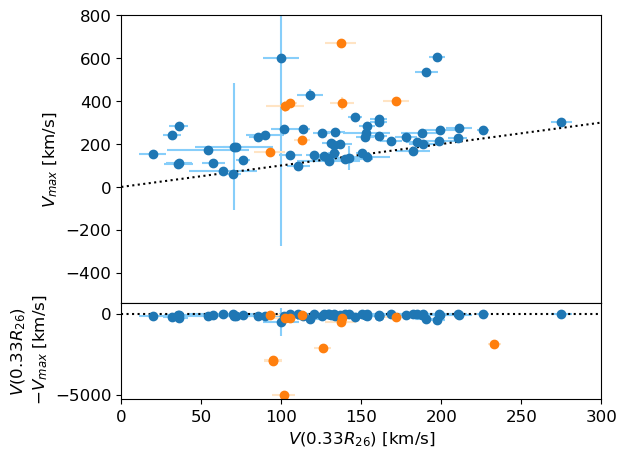

In [86]:
fig = plt.figure()

frame1 = fig.add_axes((0.2, 0.35, 0.75, 0.6))

plt.errorbar(SGA_MaNGA['V_0p33R26'][final_sample], SGA_MaNGA['Vmax_map'][final_sample], 
             yerr=SGA_MaNGA['Vmax_err_map'][final_sample], 
             xerr=SGA_MaNGA['V_0p33R26_ERR'][final_sample], 
             fmt='o', 
             ecolor='lightskyblue')
plt.errorbar(SGA_MaNGA['V_0p33R26'][good_V & (~goodVmax | ~lowVmax)], SGA_MaNGA['Vmax_map'][good_V & (~goodVmax | ~lowVmax)], 
             yerr=SGA_MaNGA['Vmax_err_map'][good_V & (~goodVmax | ~lowVmax)], 
             xerr=SGA_MaNGA['V_0p33R26_ERR'][good_V & (~goodVmax | ~lowVmax)], 
             fmt='o', 
             ecolor='bisque')
plt.plot([0, 1000], [0, 1000], 'k:')

plt.ylim(ymax=800)
plt.xlim(0, 300)

plt.ylabel('$V_{max}$ [km/s]')

frame1.axes.get_xaxis().set_visible(False)


frame2 = fig.add_axes((0.2, 0.15, 0.75, 0.2))

plt.errorbar(SGA_MaNGA['V_0p33R26'][final_sample], SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['V_0p33R26_ERR'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.errorbar(SGA_MaNGA['V_0p33R26'][good_V & (~goodVmax | ~lowVmax)], SGA_MaNGA['V_0p33R26'][good_V & (~goodVmax | ~lowVmax)] - SGA_MaNGA['Vmax_map'][good_V & (~goodVmax | ~lowVmax)], 
             xerr=SGA_MaNGA['V_0p33R26_ERR'][good_V & (~goodVmax | ~lowVmax)], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][good_V & (~goodVmax | ~lowVmax)]**2 + SGA_MaNGA['Vmax_err_map'][good_V & (~goodVmax | ~lowVmax)]**2), 
             fmt='o', 
             ecolor='bisque')
plt.hlines(0, 0, 350, linestyles='dotted', colors='k')

plt.xlim(0, 300)
#plt.ylim(-500, 150)

plt.ylabel('$V(0.33R_{26})$\n $- V_{max}$ [km/s]')
plt.xlabel('$V(0.33R_{26})$ [km/s]');

#plt.savefig('../Figures/SV/fuji_MaNGA-Vmax_comparison.eps', dpi=300);

## How do these residuals depend on redshift?

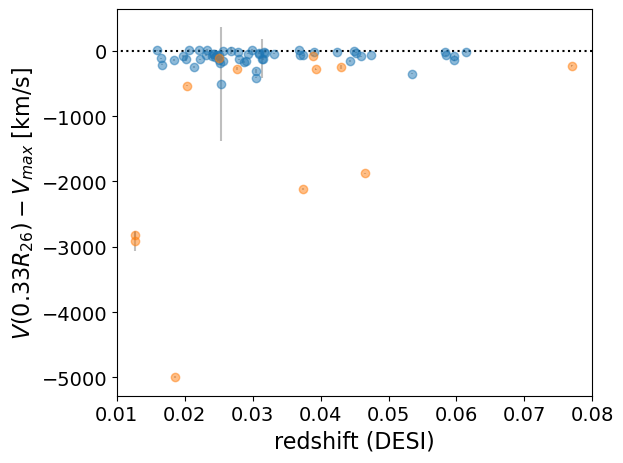

In [87]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray')
plt.errorbar(SGA_MaNGA['Z_DESI'][good_V & (~goodVmax | ~lowVmax)], 
             SGA_MaNGA['V_0p33R26'][good_V & (~goodVmax | ~lowVmax)] - SGA_MaNGA['Vmax_map'][good_V & (~goodVmax | ~lowVmax)], 
             xerr=SGA_MaNGA['ZERR_DESI'][good_V & (~goodVmax | ~lowVmax)], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][good_V & (~goodVmax | ~lowVmax)]**2 + SGA_MaNGA['Vmax_err_map'][good_V & (~goodVmax | ~lowVmax)]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray')
# plt.scatter(SGA_MaNGA['Z_DESI'][final_sample], 
#             SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
#             c=SGA_MaNGA['BA'][final_sample], 
#             vmin=0.2, vmax=1, 
#             zorder=1)
plt.hlines(0, 0, 0.08, linestyles='dotted', colors='k', zorder=2)
# plt.colorbar(label='b/a (SGA)')

plt.xlim(0.01, 0.08)
#plt.ylim(-600, 75)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('redshift (DESI)', fontsize=16)
plt.ylabel('$V(0.33R_{26}) - V_{max}$ [km/s]', fontsize=16);

#plt.savefig('../Figures/SV/MaNGA_fuji_deltaVmax-vs-z_20230823.png', dpi=150);

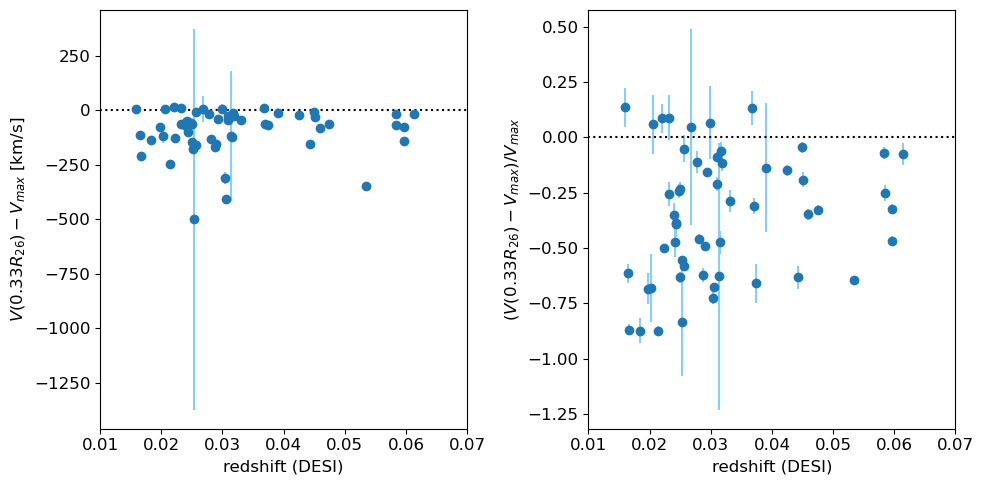

In [88]:
plt.figure(tight_layout=True, figsize=(10,5))

plt.subplot(121)

plt.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 0.08, linestyles='dotted', colors='k')

plt.xlim(0.01, 0.07)
#plt.ylim(-325, 75)

plt.xlabel('redshift (DESI)')
plt.ylabel('$V(0.33R_{26}) - V_{max}$ [km/s]')


plt.subplot(122)

plt.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             (SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + (SGA_MaNGA['V_0p33R26'][final_sample]/SGA_MaNGA['Vmax_map'][final_sample])**2 * SGA_MaNGA['Vmax_err_map'][final_sample]**2)/SGA_MaNGA['Vmax_map'][final_sample], 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 0.08, linestyles='dotted', colors='k')

plt.xlim(0.01, 0.07)
#plt.ylim(-1, 0.6)

plt.xlabel('redshift (DESI)')
plt.ylabel('($V(0.33R_{26}) - V_{max}$)/$V_{max}$');

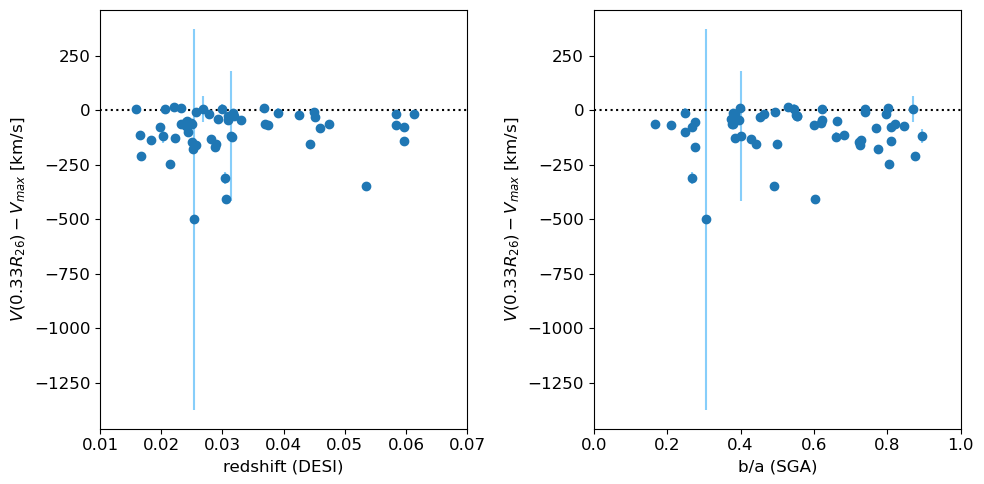

In [89]:
plt.figure(tight_layout=True, figsize=(10,5))

plt.subplot(121)

plt.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 0.08, linestyles='dotted', colors='k')

plt.xlim(0.01, 0.07)
#plt.ylim(-325, 75)

plt.xlabel('redshift (DESI)')
plt.ylabel('$V(0.33R_{26}) - V_{max}$ [km/s]')


plt.subplot(122)

plt.errorbar(SGA_MaNGA['BA'][final_sample], 
             SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 1, linestyles='dotted', colors='k')

plt.xlim(0, 1)
#plt.ylim(-1, 0.6)

plt.xlabel('b/a (SGA)')
plt.ylabel('$V(0.33R_{26}) - V_{max}$ [km/s]');

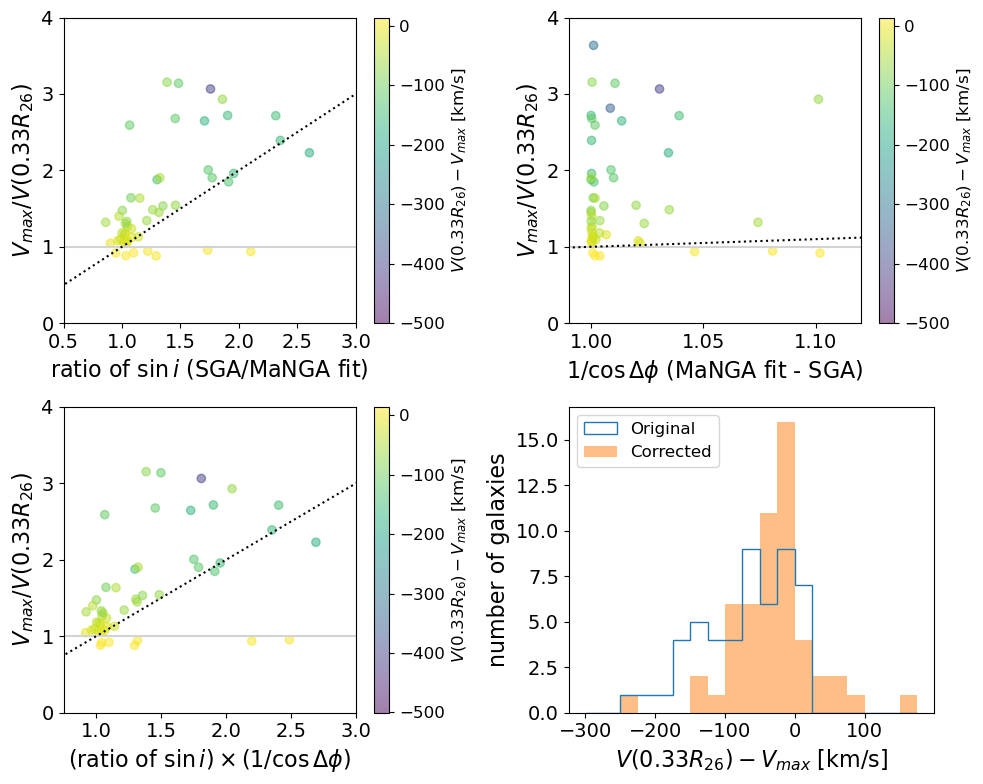

In [90]:
plt.figure(tight_layout=True, figsize=(10,8))

plt.subplot(221)

cosi2_sga = (SGA_MaNGA['BA']**2 - q0**2)/(1 - q0**2)
cosi2_manga = (SGA_MaNGA['ba_map']**2 - q0**2)/(1 - q0**2)

cosi2_sga[cosi2_sga < 0] = 0.
cosi2_manga[cosi2_manga < 0] = 0.

plt.scatter(np.sin(np.arccos(np.sqrt(cosi2_sga[final_sample])))/np.sin(np.arccos(np.sqrt(cosi2_manga[final_sample]))), 
             SGA_MaNGA['Vmax_map'][final_sample]/SGA_MaNGA['V_0p33R26'][final_sample], 
             c=SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample],
             alpha=0.5)
plt.hlines(1, 0, 5, colors='lightgray')
plt.plot([0,5], [0,5], 'k:')

plt.xlim(0.5, 3)
plt.ylim(0, 4)

plt.colorbar(label='$V(0.33R_{26}) - V_{max}$ [km/s]')

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('ratio of $\sin i$ (SGA/MaNGA fit)', fontsize=16)
plt.ylabel('$V_{max}/V(0.33R_{26})$', fontsize=16);


plt.subplot(222)

delta_pa = np.abs((SGA_MaNGA['phi_map']%180.) - SGA_MaNGA['PA'])
delta_pa[delta_pa > 90.] = 180. - delta_pa[delta_pa > 90.]

plt.scatter(1./np.cos(delta_pa[final_sample]*np.pi/180.), 
             SGA_MaNGA['Vmax_map'][final_sample]/SGA_MaNGA['V_0p33R26'][final_sample], 
             c=SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample],
             alpha=0.5)
plt.hlines(1, 0, 5, colors='lightgray')
plt.plot([0,2], [0,2], 'k:')

plt.xlim(0.99, 1.12)
plt.ylim(0, 4)

plt.colorbar(label='$V(0.33R_{26}) - V_{max}$ [km/s]')

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$1/\cos \Delta \phi$ (MaNGA fit - SGA)', fontsize=16)
plt.ylabel('$V_{max}/V(0.33R_{26})$', fontsize=16);


plt.subplot(223)

plt.scatter((1./np.cos(delta_pa[final_sample]*np.pi/180.))*(np.sin(np.arccos(np.sqrt(cosi2_sga[final_sample])))/np.sin(np.arccos(np.sqrt(cosi2_manga[final_sample])))), 
             SGA_MaNGA['Vmax_map'][final_sample]/SGA_MaNGA['V_0p33R26'][final_sample], 
             c=SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample],
             alpha=0.5)
plt.hlines(1, 0, 5, colors='lightgray')
plt.plot([0,5], [0,5], 'k:')

plt.xlim(0.75, 3)
plt.ylim(0, 4)

plt.colorbar(label='$V(0.33R_{26}) - V_{max}$ [km/s]')

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel(r'(ratio of $\sin i) \times (1/\cos \Delta \phi$)', fontsize=16)
plt.ylabel('$V_{max}/V(0.33R_{26})$', fontsize=16);


plt.subplot(224)

corrected_residuals = (1./np.cos(delta_pa*np.pi/180.))*(np.sin(np.arccos(np.sqrt(cosi2_sga)))/np.sin(np.arccos(np.sqrt(cosi2_manga))))*SGA_MaNGA['V_0p33R26'] - SGA_MaNGA['Vmax_map']

plt.hist(SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], bins=np.arange(-300, 200, 25), histtype='step', label='Original')
plt.hist(corrected_residuals[final_sample], alpha=0.5, bins=np.arange(-300, 200, 25), label='Corrected')

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$V(0.33R_{26}) - V_{max}$ [km/s]', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


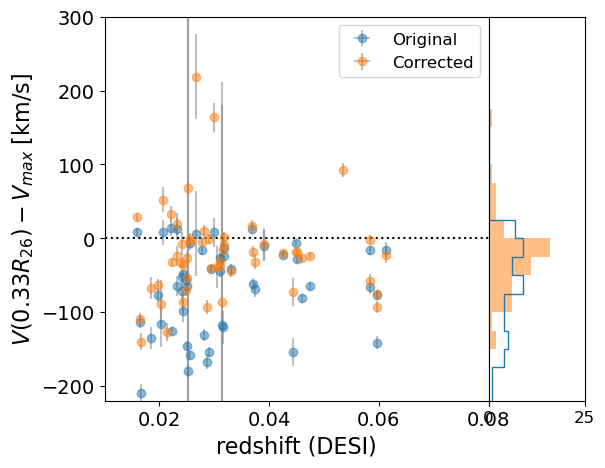

In [91]:
fig = plt.figure(tight_layout=True)

frame1 = fig.add_axes((0.2, 0.15, 0.6, 0.8))

plt.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray', 
             label='Original')
plt.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             corrected_residuals[final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray', 
             label='Corrected')
plt.hlines(0, 0, 0.08, linestyles='dotted', colors='k', zorder=2)

plt.xlim(0.01, 0.08)
plt.ylim(-220, 300)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.legend()

plt.xlabel('redshift (DESI)', fontsize=16)
plt.ylabel('$V(0.33R_{26}) - V_{max}$ [km/s]', fontsize=16)


frame2 = fig.add_axes((0.8, 0.15, 0.15, 0.8))

plt.hist(SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], bins=np.arange(-500, 200, 25), histtype='step', orientation='horizontal', label='Original')
plt.hist(corrected_residuals[final_sample], alpha=0.5, bins=np.arange(-500, 200, 25), orientation='horizontal', label='Corrected')

plt.xlim(0, 25)
plt.ylim(-220, 300)

frame2.axes.get_yaxis().set_visible(False);

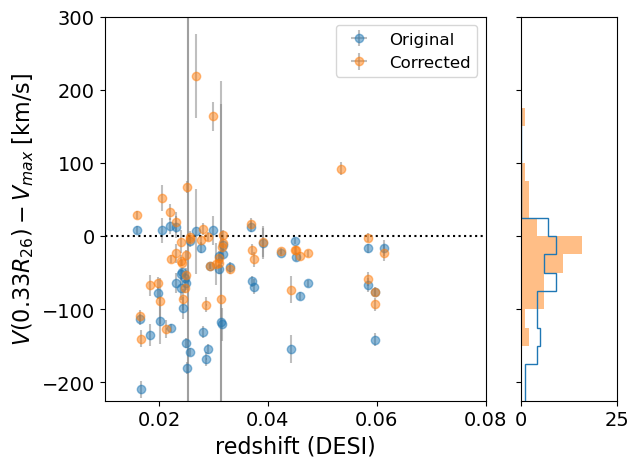

In [92]:
fig = plt.figure(tight_layout=True)

gs = fig.add_gridspec(1, 2, width_ratios=(4, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.15)

ax = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)


ax.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray', 
             label='Original')
ax.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             corrected_residuals[final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray', 
             label='Corrected')
ax.hlines(0, 0, 0.08, linestyles='dotted', colors='k')

ax.set_xlim(0.01, 0.08)
ax.set_ylim(-225, 300)

ax.tick_params(axis='both', which='major', labelsize=14)

ax.legend()

ax.set_xlabel('redshift (DESI)', fontsize=16)
ax.set_ylabel('$V(0.33R_{26}) - V_{max}$ [km/s]', fontsize=16)


ax_histy.hist(SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], bins=np.arange(-500, 200, 25), histtype='step', orientation='horizontal', label='Original')
ax_histy.hist(corrected_residuals[final_sample], alpha=0.5, bins=np.arange(-500, 200, 25), orientation='horizontal', label='Corrected')

ax_histy.set_xlim(0, 25)
ax_histy.set_ylim(-225, 300)

ax_histy.tick_params(axis='y', labelleft=False)

ax_histy.tick_params(axis='x', which='major', labelsize=14);

### Fit a line to this trend to see how far from 0 the slope is.

###### Create covariance matrix for `hyperfit`

In [61]:
Ndata = np.sum(final_sample)
cov = np.empty((2, 2, Ndata))

# Loop over arrays of uncertainties in redshift and delta V
# Assume diagonal covariance for each measurement
for i in range(Ndata):
    cov[:,:,i] = np.array([[SGA_MaNGA['ZERR_DESI'][final_sample][i], 0], [0, np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample][i]**2 + SGA_MaNGA['Vmax_err_map'][final_sample][i]**2)]])

###### Create `hyperfit` object

In [62]:
hf = LinFit([SGA_MaNGA['Z_DESI'][final_sample], SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample]], cov)
hf_corrected = LinFit([SGA_MaNGA['Z_DESI'][final_sample], corrected_residuals[final_sample]], cov)

###### Run MCMC to fit line

In [63]:
bounds = ((-10000., 10000.), (-100., 1000.), (1.0e-5, 500.))

mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
mcmc_samples_corrected, mcmc_lnlike_corrected = hf_corrected.emcee(bounds, verbose=True)

print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))
print(np.mean(mcmc_samples_corrected, axis=1), np.std(mcmc_samples_corrected, axis=1))

     fun: -212.69098089347153
 message: 'Optimization terminated successfully.'
    nfev: 6159
     nit: 134
 success: True
       x: array([ 3.29825288e-02, -2.42913643e-07,  1.13317021e-02])


100%|██████████| 1000/1000 [00:00<00:00, 2189.26it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [33.47312872 33.07759907 33.38754829] / 1673.6564358472801


100%|██████████| 1000/1000 [00:00<00:00, 2220.41it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [28.21384364 39.2216618  34.57378621] / 1961.0830902045823


100%|██████████| 1000/1000 [00:00<00:00, 2257.09it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.92473411 47.4801156  36.27646163] / 2374.0057797846075


100%|██████████| 1000/1000 [00:00<00:00, 2197.27it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.85209814 44.35422415 32.37552312] / 2242.604907047281


100%|██████████| 1000/1000 [00:00<00:00, 2204.71it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.57623942 41.41460245 33.42359358] / 2378.811971203179


100%|██████████| 1000/1000 [00:00<00:00, 2077.99it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.89517292 37.99213338 36.52243761] / 2144.758645994662


100%|██████████| 1000/1000 [00:00<00:00, 2373.24it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.12398857 37.35365349 39.47789511] / 2306.1994283625145


100%|██████████| 1000/1000 [00:00<00:00, 2309.31it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.783831   39.28653281 40.98128913] / 2089.1915499869756


100%|██████████| 1000/1000 [00:00<00:00, 2395.30it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.367425   40.54803656 40.83262823] / 2268.3712499655576


100%|██████████| 1000/1000 [00:00<00:00, 2330.51it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.25823898 44.76271845 45.33139935] / 2412.911949161965


100%|██████████| 1000/1000 [00:00<00:00, 2397.36it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.04718234 47.25110071 44.53300488] / 2362.55503539295


100%|██████████| 1000/1000 [00:00<00:00, 2345.93it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [50.44231653 50.43569797 46.88997037] / 2522.115826306168


100%|██████████| 1000/1000 [00:00<00:00, 2373.23it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [55.92630272 55.75537108 44.06512633] / 2796.3151359540097


100%|██████████| 1000/1000 [00:00<00:00, 2407.74it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [52.134894   54.30859574 42.18535297] / 2715.4297869910883


100%|██████████| 1000/1000 [00:00<00:00, 2307.58it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [49.98522709 50.94711085 41.60798977] / 2547.3555424850124


100%|██████████| 1000/1000 [00:00<00:00, 1795.14it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [49.37104284 46.15128268 41.59517256] / 2468.552141839379


100%|██████████| 1000/1000 [00:00<00:00, 1989.52it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [50.35423192 46.50631931 43.68254859] / 2517.711596030763
     fun: -212.75315751661847
 message: 'Optimization terminated successfully.'
    nfev: 5034
     nit: 109
 success: True
       x: array([ 3.25517207e-02, -4.27092345e-07,  1.13044615e-02])


100%|██████████| 1000/1000 [00:00<00:00, 2329.93it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [33.28406334 36.21110609 31.60861175] / 1810.5553047147548


100%|██████████| 1000/1000 [00:00<00:00, 2290.76it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.62351855 44.38035544 27.58235312] / 2219.017772145331


100%|██████████| 1000/1000 [00:00<00:00, 2322.74it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.13431975 42.79751215 33.08949126] / 2139.875607409103


100%|██████████| 1000/1000 [00:00<00:00, 2276.50it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.07088704 34.34874631 35.12992776] / 1853.5443521287523


100%|██████████| 1000/1000 [00:00<00:00, 2320.30it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.96314524 33.30419514 40.65487823] / 2032.7439114078081


100%|██████████| 1000/1000 [00:00<00:00, 2321.09it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.39296133 34.33997946 37.63206962] / 1969.6480664956823


100%|██████████| 1000/1000 [00:00<00:00, 2322.89it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.18302478 35.24800386 38.59714447] / 2159.151239030206


100%|██████████| 1000/1000 [00:00<00:00, 2333.70it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.83521111 37.39179336 40.10277479] / 2241.760555378343


100%|██████████| 1000/1000 [00:00<00:00, 2263.14it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.3138832  38.19214662 45.56425037] / 2278.2125187144347


100%|██████████| 1000/1000 [00:00<00:00, 2289.72it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.62765676 39.02570098 42.22570548] / 2131.3828378117455


100%|██████████| 1000/1000 [00:00<00:00, 2271.41it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.8170011  40.66306769 41.04181184] / 2290.850055175501


100%|██████████| 1000/1000 [00:00<00:00, 2298.81it/s]

Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.1944294  41.34415101 41.72888778] / 2309.72147018143
[70755.84411195 -2430.81320235  5581.32633253] [9117885.22213307  296142.1453618   109546.55846489]
[-31528.86381203    926.67353308   4145.40916146] [21304735.62702162   662477.11547488   264350.94057469]


###### Plot the Hyperfit

After the linear fit MCMC, construct the best-fit line and its 1$\sigma$ uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in redshift and $\Delta V$.

In [64]:
a, b, sig = np.median(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)

for val, err in zip((a, b, sig), (da, db, dsig)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))
    
    
a_corrected, b_corrected, sig_corrected = np.median(mcmc_samples_corrected, axis=1)
da_corrected, db_corrected, dsig_corrected = np.std(mcmc_samples_corrected, axis=1)

for val, err in zip((a_corrected, b_corrected, sig_corrected), (da_corrected, db_corrected, dsig_corrected)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

47400.84 +/- 9117885.22
-1632.93 +/- 296142.15
994.97 +/- 109546.56
33362.76 +/- 21304735.63
-1098.17 +/- 662477.12
656.75 +/- 264350.94


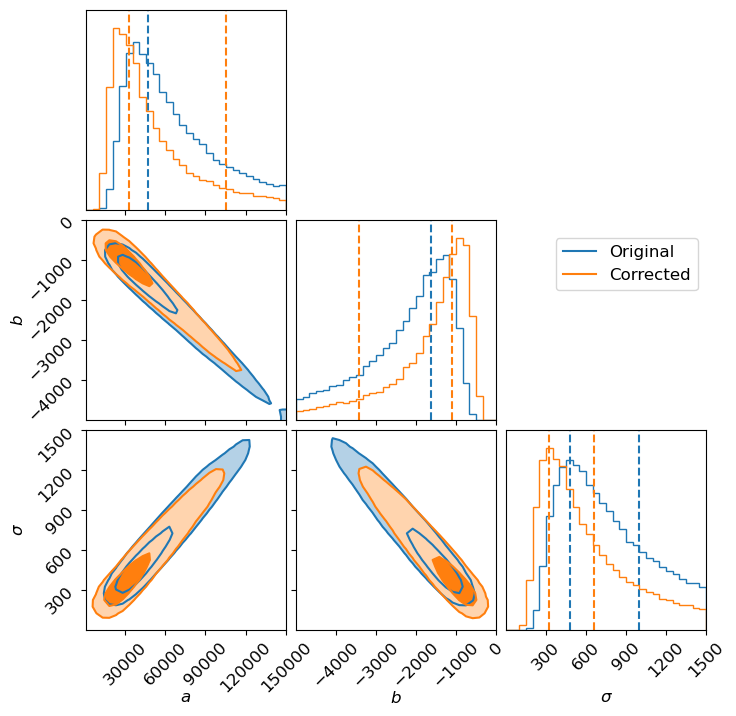

In [67]:
corner_kwargs = dict(bins=30, 
                     smooth=1, 
                     range=[[1000, 150000], [-5000, 0], [0, 1500]],   # Range for a, b, sigma. Adjust as needed
                     labels=['$a$', '$b$', r'$\sigma$'], 
                     levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                     quantiles=[0.16, 0.5, 0.84],
                     plot_datapoints=False,
                     fill_contours=True,
                     title_kwargs={"fontsize": 14})

fig = corner.corner(mcmc_samples.T, color='tab:blue', **corner_kwargs)

corner.corner(mcmc_samples_corrected.T, fig=fig, color='tab:orange', **corner_kwargs)

plt.legend(handles=[mlines.Line2D([], [], color=c, label=l) for c,l in zip(['tab:blue', 'tab:orange'], ['Original', 'Corrected'])], 
           bbox_to_anchor=(1,2), 
           loc='upper right');

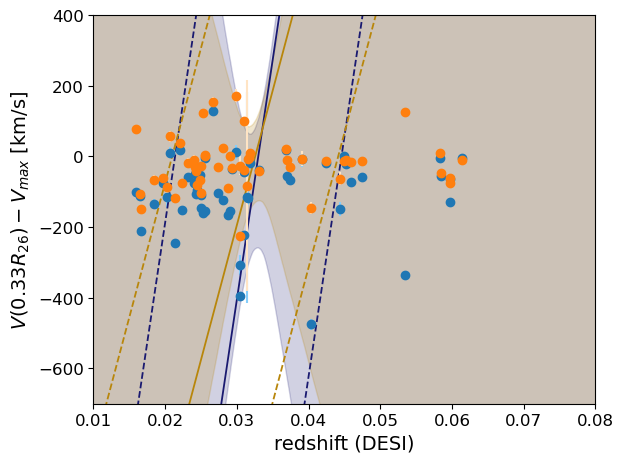

In [68]:
sigmas = hf.get_sigmas()
xvals = np.linspace(0., 0.1, 1000)
yvals = hf.coords[0] * xvals + hf.coords[1]
#-----------------------
sigmas_corrected = hf_corrected.get_sigmas()
yvals_corrected = hf_corrected.coords[0] * xvals + hf_corrected.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)
#-----------------------
y_chain_corrected = np.outer(xvals, mcmc_samples_corrected[0]) + mcmc_samples_corrected[1]
y_chain_corrected_quantiles = np.quantile(y_chain_corrected, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [SGA_MaNGA['Z_DESI'][final_sample], SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample]]
x_err = SGA_MaNGA['ZERR_DESI'][final_sample]
y_err = np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2)
corr_xy = np.zeros_like(x_err)
#-----------------------
data_corrected = [SGA_MaNGA['Z_DESI'][final_sample], corrected_residuals[final_sample]]

# Make the plot
fig, ax = plt.subplots(tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="midnightblue", alpha=0.2)
ax.errorbar(data[0], data[1], xerr=x_err, yerr=y_err, fmt='o', ecolor='lightskyblue')
ax.plot(xvals, yvals, c="midnightblue", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals - hf.vert_scat, c="midnightblue", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals + hf.vert_scat, c="midnightblue", marker="None", ls="--", lw=1.3)#, alpha=0.9)

ax.fill_between(xvals, y_chain_corrected_quantiles[0], y_chain_corrected_quantiles[1], color="darkgoldenrod", alpha=0.2)
ax.errorbar(data_corrected[0], data_corrected[1], xerr=x_err, yerr=y_err, fmt='o', ecolor='bisque')
ax.plot(xvals, yvals_corrected, c="darkgoldenrod", marker="None", ls="-", lw=1.3)
ax.plot(xvals, yvals_corrected - hf_corrected.vert_scat, c="darkgoldenrod", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals_corrected + hf_corrected.vert_scat, c="darkgoldenrod", marker="None", ls="--", lw=1.3)#, alpha=0.9)

ax.set_xlabel("redshift (DESI)", fontsize=14)
ax.set_ylabel(r"$V(0.33R_{26}) - V_{max}$ [km/s]", fontsize=14)
#ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF)), fontsize = 14)
ax.set_xlim(0.01, 0.08);
ax.set_ylim(-700, 400);

###### Segev doesn't trust `hyperfit` here, so a second way of fitting this data:

In [69]:
# Quick linear fit.
z = SGA_MaNGA['Z_DESI'][final_sample]
deltav = SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample]
deltav_corrected = corrected_residuals[final_sample]
deltav_err = np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2)

A = np.vander(z, 2)
C = np.diag(deltav_err * deltav_err)
ATA = np.dot(A.T, A / (deltav_err**2)[:,None])
cov = np.linalg.inv(ATA)

w = np.linalg.solve(ATA, np.dot(A.T, deltav / deltav_err ** 2))
w_corrected = np.linalg.solve(ATA, np.dot(A.T, deltav_corrected/deltav_err**2))

a, b = w[::-1]
a_corrected, b_corrected = w_corrected[::-1]

print(a, b)
print(a_corrected, b_corrected)

-184.28779387372614 3425.8398525542907
-63.2630279903199 1167.9607193170325


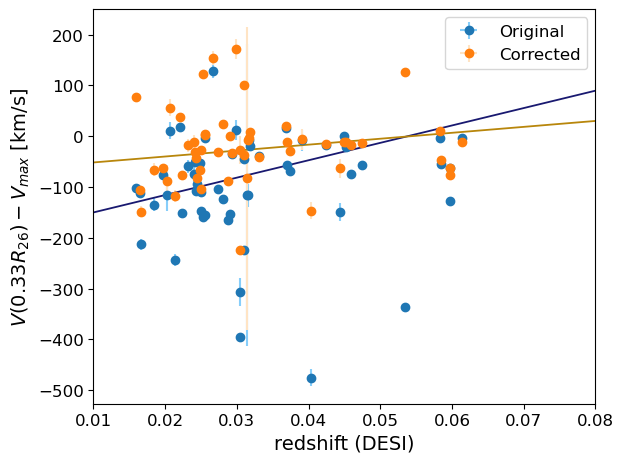

In [70]:
xvals = np.linspace(0., 0.1, 1000)
yvals = b * xvals + a
yvals_corrected = b_corrected*xvals + a_corrected

plt.figure(tight_layout=True)

plt.errorbar(z, deltav, xerr=SGA_MaNGA['ZERR_DESI'][final_sample], yerr=deltav_err, fmt='o', ecolor='lightskyblue', label='Original')
plt.errorbar(z, deltav_corrected, xerr=SGA_MaNGA['ZERR_DESI'][final_sample], yerr=deltav_err, fmt='o', ecolor='bisque', label='Corrected')

plt.plot(xvals, yvals, c="midnightblue", lw=1.3)#, alpha=0.9)
plt.plot(xvals, yvals_corrected, c='darkgoldenrod', lw=1.3)

plt.legend()

plt.xlabel("redshift (DESI)", fontsize=14)
plt.ylabel(r"$V(0.33R_{26}) - V_{max}$ [km/s]", fontsize=14)
plt.xlim(0.01, 0.08);
#plt.ylim(-325, 75);

###### And fitting using $\chi^2$:

In [71]:
def linear_model(b, m, x):
    return m*x + b


def calculate_chi2(params, x, x_err, y, y_err):
    
    m, b = params
    
    y_fit = linear_model(b, m, x)
    
    chi2 = np.sum((y - y_fit)**2 / (y_err**2 + (m*x_err)**2))
    
    return chi2 #/ (len(x) - 2)

def chi2_linear(params, x, dx, y, dy):
    a, b = params
    return np.sum((y - a - b*x)**2 / (dy**2 + (b*dx)**2))

def chi2_const(params, x, dx, y, dy):
    a = params
    return np.sum((y - a)**2 / dy**2)

In [72]:
a_guess = 50.
b_guess = -1500.

rng = np.random.default_rng()

best_fun_linear = np.inf
best_fun_linear_corrected = np.inf

for i in tqdm(range(1000)):
    
    result = minimize(chi2_linear, 
                      [a_guess + (rng.random()*500 - 250), b_guess + (rng.random()*20000 - 10000)], 
                      # [m_guess + (rng.random()*20000 - 10000), b_guess + (rng.random()*500 - 250)], 
                      args=(SGA_MaNGA['Z_DESI'][final_sample], 
                            SGA_MaNGA['ZERR_DESI'][final_sample], 
                            SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
                            np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2)))
    
    if result.success and (result.fun < best_fun_linear):
        best_fun_linear = result.fun
        best_result_linear = result
        
    
    result_corrected = minimize(chi2_linear, 
                                [a_guess + (rng.random()*500 - 250), b_guess + (rng.random()*20000 - 10000)], 
                                # [m_guess + (rng.random()*20000 - 10000), b_guess + (rng.random()*500 - 250)], 
                                args=(SGA_MaNGA['Z_DESI'][final_sample], 
                                      SGA_MaNGA['ZERR_DESI'][final_sample], 
                                      corrected_residuals[final_sample], 
                                      np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2)))
    
    if result_corrected.success and (result_corrected.fun < best_fun_linear_corrected):
        best_fun_linear_corrected = result_corrected.fun
        best_result_linear_corrected = result_corrected

print(f'{best_result_linear}\n')
print(f'{best_result_linear_corrected}\n')

for j, par in enumerate('ab'):
    p = best_result_linear.x[j]
    dp = np.sqrt(np.diag(best_result_linear.hess_inv))[j]
    
    p_corrected = best_result_linear_corrected.x[j]
    dp_corrected = np.sqrt(np.diag(best_result_linear_corrected.hess_inv))[j]
    
    print(f'{par} = {p:8.2f} +- {dp:8.2f}; {p_corrected:8.2f} +- {dp_corrected:8.2f}')

100%|██████████| 1000/1000 [00:48<00:00, 20.61it/s]

      fun: 18614.919386660655
 hess_inv: array([[   2.59600634,  -77.2124971 ],
       [ -77.2124971 , 2339.59808478]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 96
      nit: 17
     njev: 32
   status: 0
  success: True
        x: array([-184.29825575, 3426.14198557])

      fun: 8099.690711377808
 hess_inv: array([[ 0.0317802 , -0.36755078],
       [-0.36755078, 21.74517085]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 108
      nit: 15
     njev: 36
   status: 0
  success: True
        x: array([ -63.26510582, 1168.02559187])

a =  -184.30 +-     1.61;   -63.27 +-     0.18
b =  3426.14 +-    48.37;  1168.03 +-     4.66


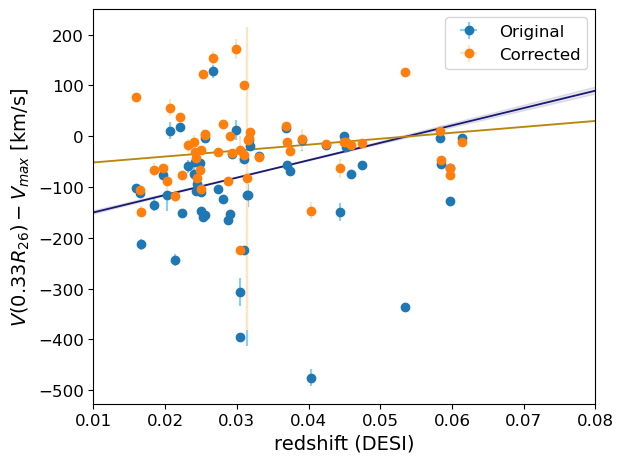

In [73]:
a, b = best_result_linear.x
a_corrected, b_corrected = best_result_linear_corrected.x

xvals = np.linspace(0., 0.1, 1000)
yvals = b * xvals + a
yvals_corrected = b_corrected * xvals + a_corrected

plt.figure(tight_layout=True)

plt.errorbar(z, deltav, xerr=SGA_MaNGA['ZERR_DESI'][final_sample], yerr=deltav_err, fmt='o', ecolor='lightskyblue', label='Original')
plt.errorbar(z, deltav_corrected, xerr=SGA_MaNGA['ZERR_DESI'][final_sample], yerr=deltav_err, fmt='o', ecolor='bisque', label='Corrected')

plt.plot(xvals, yvals, c="midnightblue", lw=1.3)#, alpha=0.9)
plt.plot(xvals, yvals_corrected, c="darkgoldenrod", lw=1.3)

ymin = np.full_like(xvals, np.inf)
ymax = np.full_like(xvals, -np.inf)
ymin_corrected = np.full_like(xvals, np.inf)
ymax_corrected = np.full_like(xvals, -np.inf)
for j in range(1000):
    a_, b_ = np.random.multivariate_normal(best_result_linear.x, best_result_linear.hess_inv)
    yvals = a_ + b_*xvals
    ymin = np.minimum(ymin, yvals)
    ymax = np.maximum(ymax, yvals)
    
    a_corrected_, b_corrected_ = np.random.multivariate_normal(best_result_linear_corrected.x, best_result_linear_corrected.hess_inv)
    yvals_corrected = a_corrected_ + b_corrected_*xvals
    ymin_corrected = np.minimum(ymin_corrected, yvals_corrected)
    ymax_corrected = np.maximum(ymax_corrected, yvals_corrected)
plt.fill_between(xvals, ymin, ymax, color='midnightblue', alpha=0.1)
plt.fill_between(xvals, ymin_corrected, ymax_corrected, color='darkgoldenrod', alpha=0.1)

plt.legend()

plt.xlabel("redshift (DESI)", fontsize=14)
plt.ylabel(r"$V(0.33R_{26}) - V_{max}$ [km/s]", fontsize=14)
plt.xlim(0.01, 0.08);
#plt.ylim(-325, 75);

In [74]:
a_guess = 50.

rng = np.random.default_rng()

best_fun_const = np.inf
best_fun_const_corrected = np.inf

for i in tqdm(range(1000)):
    
    result = minimize(chi2_const, 
                      [a_guess + (rng.random()*500 - 250)], 
                      # [m_guess + (rng.random()*20000 - 10000), b_guess + (rng.random()*500 - 250)], 
                      args=(SGA_MaNGA['Z_DESI'][final_sample], 
                            SGA_MaNGA['ZERR_DESI'][final_sample], 
                            SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
                            np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2)))
    
    if result.success and (result.fun < best_fun_const):
        best_fun_const = result.fun
        best_result_const = result
        
        
    result_corrected = minimize(chi2_const, 
                                [a_guess + (rng.random()*500 - 250)], 
                                # [m_guess + (rng.random()*20000 - 10000), b_guess + (rng.random()*500 - 250)], 
                                args=(SGA_MaNGA['Z_DESI'][final_sample], 
                                      SGA_MaNGA['ZERR_DESI'][final_sample], 
                                      corrected_residuals[final_sample], 
                                      np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2)))
    
    if result_corrected.success and (result_corrected.fun < best_fun_const_corrected):
        best_fun_const_corrected = result_corrected.fun
        best_result_const_corrected = result_corrected

print(f'{best_result_const}\n')
print(f'{best_result_const_corrected}\n')

for j, par in enumerate('a'):
    p = best_result_const.x[j]
    dp = np.sqrt(np.diag(best_result_const.hess_inv))[j]
    
    p_corrected = best_result_const_corrected.x[j]
    dp_corrected = np.sqrt(np.diag(best_result_const_corrected.hess_inv))[j]
    
    print(f'{par} = {p:8.2f} +- {dp:8.2f}; {p_corrected:8.2f} +- {dp_corrected:8.2f}')

100%|██████████| 1000/1000 [00:06<00:00, 144.68it/s]

      fun: 28095.786482778512
 hess_inv: array([[0.04606398]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 26
      nit: 4
     njev: 13
   status: 0
  success: True
        x: array([-75.11836491])

      fun: 9201.598026684862
 hess_inv: array([[0.04521089]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 50
      nit: 5
     njev: 25
   status: 0
  success: True
        x: array([-26.04424093])

a =   -75.12 +-     0.21;   -26.04 +-     0.21


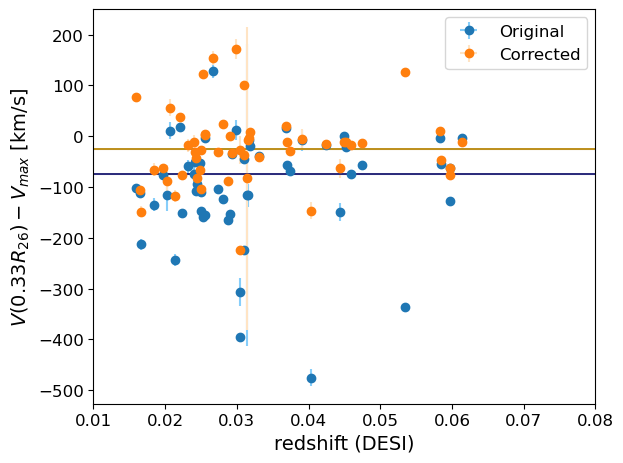

In [75]:
a = best_result_const.x
a_corrected = best_result_const_corrected.x

da = np.sqrt(np.diag(best_result_const.hess_inv))[0]
da_corrected = np.sqrt(np.diag(best_result_const_corrected.hess_inv))[0]

xvals = np.linspace(0., 0.1, 1000)
yvals = 0. * xvals + a
yvals_corrected = 0. * xvals + a_corrected

plt.figure(tight_layout=True)

plt.errorbar(z, deltav, xerr=SGA_MaNGA['ZERR_DESI'][final_sample], yerr=deltav_err, fmt='o', ecolor='lightskyblue', label='Original')
plt.errorbar(z, deltav_corrected, xerr=SGA_MaNGA['ZERR_DESI'][final_sample], yerr=deltav_err, fmt='o', ecolor='bisque', label='Corrected')

plt.plot(xvals, yvals, c="midnightblue", lw=1.3)#, alpha=0.9)
plt.plot(xvals, yvals_corrected, c="darkgoldenrod", lw=1.3)

plt.fill_between(xvals, a-da, a+da, color='midnightblue', alpha=0.1)
plt.fill_between(xvals, a_corrected-da_corrected, a_corrected+da_corrected, color='darkgoldenrod', alpha=0.1)

plt.legend()

plt.xlabel("redshift (DESI)", fontsize=14)
plt.ylabel(r"$V(0.33R_{26}) - V_{max}$ [km/s]", fontsize=14)
plt.xlim(0.01, 0.08);
#plt.ylim(-325, 75);

#### $\Delta\chi^2$ Test

Compute the $\chi^2$ difference between the linear and constant fits to the residuals. It should be distributed as

$$
\Delta\chi^2 = \chi^2_\mathrm{const} - \chi^2_\mathrm{linear} \sim \chi^2_1,
$$

so we can compute the $p$-value

$$
p = \mathrm{Pr}(\Delta\chi^2 \geq \chi^2_N|N=1).
$$

This gives the chance probability that the data are constant but have fluctuated enough to prefer the linear rather than the constant model. Larger $p$-values mean the simpler hypothesis of a constant function is preferred.

In [76]:
deltachi2 = best_fun_const - best_fun_linear
p = stats.chi2.sf(deltachi2, 1)
sigma = stats.norm.isf(p)
print(f'p = {p:g}, a {sigma:.1f} sigma chance probability.')

p = 0, a inf sigma chance probability.


In [77]:
deltachi2_corrected = best_fun_const_corrected - best_fun_linear_corrected
p_corrected = stats.chi2.sf(deltachi2_corrected, 1)
sigma_corrected = stats.norm.isf(p_corrected)
print(f'p = {p_corrected:g}, a {sigma_corrected:.1f} sigma chance probability.')

p = 1.27157e-241, a 33.2 sigma chance probability.


In [78]:
hessian = ndt.Hessian(chi2_linear)
hess_ll = hessian(best_result_linear.x, 
                  SGA_MaNGA['Z_DESI'][final_sample], 
                  SGA_MaNGA['ZERR_DESI'][final_sample], 
                  SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
                  np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2))
hess_inv = np.linalg.inv(hess_ll)

uncertainty = np.sqrt(np.diag(hess_inv))

for i in range(2):
    print('{:6.2f} +/- {:.2f}'.format(best_result_linear.x[i], uncertainty[i]))

-184.30 +/- 0.82
3426.14 +/- 24.88


In [98]:
hess_ll_corrected = hessian(best_result_linear_corrected.x, 
                  SGA_MaNGA['Z_DESI'][final_sample], 
                  SGA_MaNGA['ZERR_DESI'][final_sample], 
                  corrected_residuals[final_sample], 
                  np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2))
hess_inv_corrected = np.linalg.inv(hess_ll_corrected)

uncertainty_corrected = np.sqrt(np.diag(hess_inv_corrected))

for i in range(2):
    print('{:6.2f} +/- {:.2f}'.format(best_result_linear_corrected.x[i], uncertainty_corrected[i]))

-63.27 +/- 0.82
1168.03 +/- 24.88


###### And fitting using least squares (Segev's code)

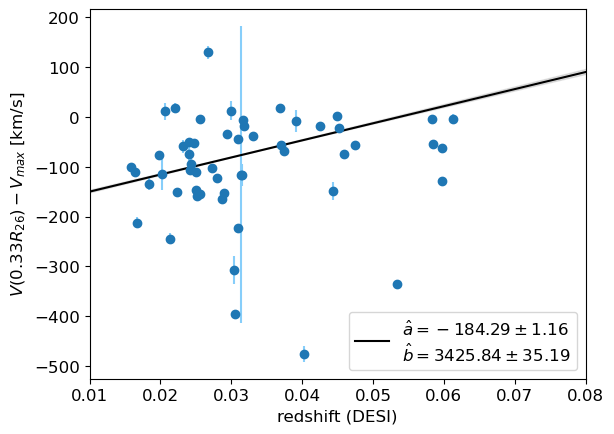

In [79]:
def leastsq(x, y, dy):
    """Analytical linear least squares fit.
    
    Parameters
    ----------
    x : list or ndarray
        List of independent "ordinates."
    y : list or ndarray
        List of dependent coordinates.
    dy : list or ndarray
        Uncertainty in dependent coordinates.
    
    Returns
    -------
    a : float
        Intercept: y = a + b*x
    b : float
        Slope: y = a + b*x
    da : float  
        Uncertainty in intercept.
    db : float  
        Uncertainty in slope.
    """
    w = 2/dy**2
    A = np.sum(w)
    B = np.sum(x**2 * w)
    C = np.sum(x*w)
    p = np.sum(y*w)
    q = np.sum(x*y*w)
    det = A*B - C**2
    
    if det == 0:
        raise ZeroDivisionError('Cannot invert singular matrix.')
    
    a = (B*p - C*q)/det
    b = (A*q - C*p)/det
    cov = 2/det * np.asarray([[B, -C], [-C, A]])
    
    return a, b, cov
    
x = SGA_MaNGA['Z_DESI'][final_sample]
#atrue, btrue = 1., 2.
y = SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample]
dy = np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2)

a, b, cov = leastsq(x, y, dy)
da, db = np.sqrt(np.diag(cov))

xvals = np.linspace(0., 0.1, 1000)
yvals = b * xvals + a

plt.errorbar(z, deltav, xerr=SGA_MaNGA['ZERR_DESI'][final_sample], yerr=deltav_err, fmt='o', ecolor='lightskyblue')
plt.plot(xvals, yvals, 'k',
         label=f'$\hat{{a}}={a:.2f}\pm{da:.2f}$\n$\hat{{b}}={b:.2f}\pm{db:.2f}$')
plt.xlabel('redshift (DESI)')
plt.ylabel('$V(0.33R_{26}) - V_{max}$ [km/s]')

ymin = np.full_like(xvals, np.inf)
ymax = np.full_like(xvals, -np.inf)
for j in range(1000):
    a_, b_ = np.random.multivariate_normal([a, b], cov)
    yvals = a_ + b_*xvals
    ymin = np.minimum(ymin, yvals)
    ymax = np.maximum(ymax, yvals)
plt.fill_between(xvals, ymin, ymax, color='k', alpha=0.1)

plt.xlim(0.01, 0.08)

plt.legend();

## How do these residuals compare to that from the MaNGA fits?

### Compute $\Delta V$ for each MaNGA fit

In [93]:
# 1 - Convert R26 to kpc for each galaxy
dist_to_galaxy_NSA = SGA_MaNGA['Z_NSA']*c/H0
R26_kpc_NSA = dist_to_galaxy_NSA.to('kpc')*np.tan((SGA_MaNGA['R26']*u.arcmin).to(u.rad))

SGA_MaNGA['Vfit_0p33R26'] = rot_fit_BB((0.33*R26_kpc_NSA).data, [SGA_MaNGA['Vmax_map'], SGA_MaNGA['Rturn_map'], SGA_MaNGA['alpha_map']])
SGA_MaNGA['Vfit_0p4R26'] = rot_fit_BB((0.4*R26_kpc_NSA).data, [SGA_MaNGA['Vmax_map'], SGA_MaNGA['Rturn_map'], SGA_MaNGA['alpha_map']])

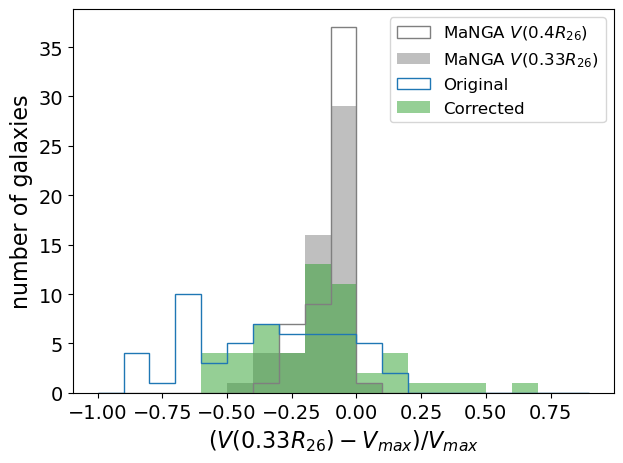

In [94]:
bins = np.arange(-1, 1, 0.1)

plt.figure(tight_layout=True)

plt.hist((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
         bins=bins, density=False, edgecolor='tab:gray', histtype='step', label='MaNGA $V(0.4R_{26})$')
plt.hist((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
         bins=bins, density=False, facecolor='gray', alpha=0.5, label='MaNGA $V(0.33R_{26})$')
plt.hist((SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
         bins=bins, density=False, edgecolor='tab:blue', histtype='step', label='Original')
plt.hist(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample], 
         alpha=0.5, bins=bins, density=False, facecolor='tab:green', label='Corrected')

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('($V(0.33R_{26}) - V_{max}$)/$V_{max}$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

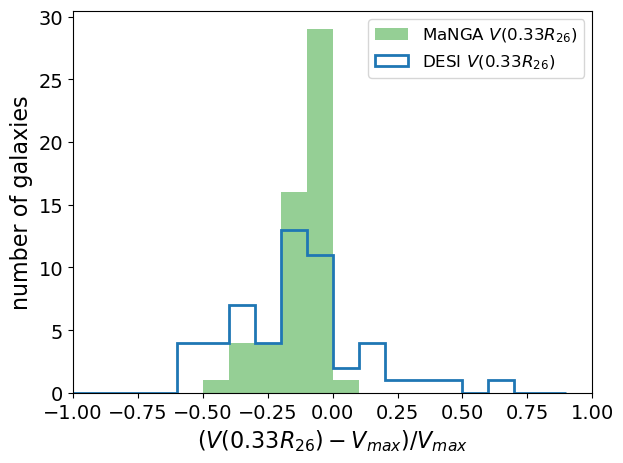

In [95]:
# Same figure as above, but for paper
bins = np.arange(-1, 1, 0.1)

plt.figure(tight_layout=True)

plt.hist((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
         bins=bins, density=False, facecolor='tab:green', alpha=0.5, label='MaNGA $V(0.33R_{26})$')
plt.hist(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample], 
         bins=bins, density=False, edgecolor='tab:blue', histtype='step', linewidth=2,
         label='DESI $V(0.33R_{26})$')

plt.xlim(-1, 1)

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('($V(0.33R_{26}) - V_{max}$)/$V_{max}$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

# plt.savefig('../../Figures/SV/fuji_MaNGA_Vdiff_comparison.png', dpi=150);

In [96]:
mean_MaNGA = np.mean((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
mean_corrected = np.mean(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample])

print('MaNGA mean (0.33R26): %.3f' % mean_MaNGA)
print('Corrected mean: %.3f' % mean_corrected)

MaNGA mean (0.33R26): -0.112
Corrected mean: -0.075


In [97]:
std_MaNGA = np.std((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
std_corrected = np.std(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample])

print('MaNGA std (0.33R26): %.3f' % std_MaNGA)
print('Corrected std: %.3f' % std_corrected)
print('DESI effect (0.33R26): %.3f' % np.sqrt(std_corrected**2 - std_MaNGA**2))

MaNGA std (0.33R26): 0.106
Corrected std: 0.391
DESI effect (0.33R26): 0.376


In [98]:
def fit_func(x, a, mu, sigma, c):
    '''
    Gaussian function
    '''
    return a*stats.norm.pdf(x, loc=mu, scale=sigma) + c


hist_manga0p33,_ = np.histogram((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
                                bins=bins)
hist_manga0p4,_ = np.histogram((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
                               bins=bins)
hist_original,_ = np.histogram((SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
                               bins=bins)
hist_corrected,_ = np.histogram(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample], 
                                bins=bins)

centers = bins[:-1] + (bins[1] - bins[0])

p0_manga0p33 = [np.max(hist_manga0p33), 
                np.mean((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample]), 
                np.std((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample]), 
                -0.1]
p0_manga0p4 = [np.max(hist_manga0p4), 
               np.mean((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample]), 
               np.std((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample]), 
                -0.1]
p0_original = [np.max(hist_original), 
               np.mean((SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample]), 
               np.std((SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample]), 
               -0.3]
p0_corrected = [np.max(hist_corrected), 
                np.mean(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample]), 
                np.std(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample]), 
                -0.1]

p1_manga0p33,_ = curve_fit(fit_func, centers, hist_manga0p33, p0_manga0p33)
p1_manga0p4,_ = curve_fit(fit_func, centers, hist_manga0p4, p0_manga0p4)
p1_original,_ = curve_fit(fit_func, centers, hist_original, p0_original)
p1_corrected,_ = curve_fit(fit_func, centers, hist_corrected, p0_corrected)

In [99]:
print('MaNGA std (0.33R26): %.3f' % p1_manga0p33[2])
print('MaNGA std (0.4R26): %.3f' % p1_manga0p4[2])
print('Corrected std: %.3f' % p1_corrected[2])
print('DESI effect (0.33R26): %.3f' % np.sqrt(p1_corrected[2]**2 - p1_manga0p33[2]**2))

MaNGA std (0.33R26): 0.051
MaNGA std (0.4R26): 0.042
Corrected std: 0.187
DESI effect (0.33R26): 0.180


In [100]:
def rms(x):
    '''
    Calculate the RMS of x
    '''
    return np.sqrt(np.sum(x**2)/len(x))


RMS_manga0p33 = rms((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
RMS_manga0p4 = rms((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
RMS_original = rms((SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
RMS_corrected = rms(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample])

In [101]:
print('MaNGA rms (0.33R26): %.3f' % RMS_manga0p33)
print('MaNGA rms (0.4R26): %.3f' % RMS_manga0p4)
print('Corrected rms: %.3f' % RMS_corrected)
print('DESI effect (0.33R26): %.3f' % np.sqrt(RMS_corrected**2 - RMS_manga0p33**2))

MaNGA rms (0.33R26): 0.155
MaNGA rms (0.4R26): 0.117
Corrected rms: 0.398
DESI effect (0.33R26): 0.366


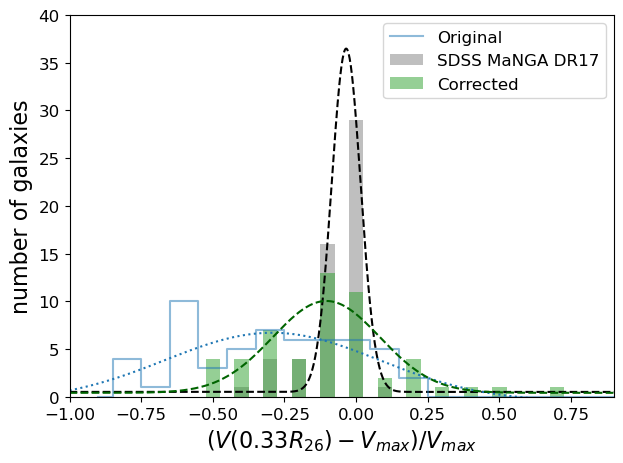

In [102]:
x = np.linspace(bins[0], bins[-1], 1000)

plt.figure(tight_layout=True)

plt.bar(centers, hist_manga0p33, width=0.05, facecolor='gray', alpha=0.5, label='SDSS MaNGA DR17')#label='MaNGA $V(0.33R_{26})$')
plt.plot(x, fit_func(x, *p1_manga0p33), '--k')

# plt.step(centers, hist_manga0p4, c='gray', where='mid', label='MaNGA $V(0.4R_{26})$')
# plt.plot(x, fit_func(x, *p1_manga0p4), ':', c='tab:gray')

plt.step(centers, hist_original, c='tab:blue', alpha=0.5, where='mid', label='Original')
plt.plot(x, fit_func(x, *p1_original), ':', c='tab:blue')

plt.bar(centers, hist_corrected, width=0.05, facecolor='tab:green', alpha=0.5, label='Corrected')
plt.plot(x, fit_func(x, *p1_corrected), '--', c='darkgreen')

plt.xlim(bins[0], bins[-1])
plt.ylim(0, 40)

plt.legend()

plt.xlabel('($V(0.33R_{26}) - V_{max}$)/$V_{max}$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

In [103]:
print('Original: mean =', np.nanmean(SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample]), '; std dev =', np.nanstd(SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample]))
print('Corrected: mean =', np.nanmean(corrected_residuals[final_sample]), '; std dev =', np.nanstd(corrected_residuals[final_sample]))
print('MaNGA: mean =', np.nanmean(SGA_MaNGA['Vfit_0p33R26'] - SGA_MaNGA['Vmax_map']), '; std dev =', np.nanstd(SGA_MaNGA['Vfit_0p33R26'] - SGA_MaNGA['Vmax_map']))

Original: mean = -94.17253886485902 ; std dev = 105.04087449022626
Corrected: mean = -18.29723653452296 ; std dev = 88.6045346590865
MaNGA: mean = -100.11896602940678 ; std dev = 399.631856147986


In [104]:
MaNGA_original = stats.ks_2samp((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
                                (SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
MaNGA_corrected = stats.ks_2samp((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
                                 corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample])
original_corrected = stats.ks_2samp((SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
                                    corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample])

print('MaNGA & Original: stat =', MaNGA_original.statistic, '; p =', MaNGA_original.pvalue)
print('MaNGA & Corrected: stat =', MaNGA_corrected.statistic, '; p =', MaNGA_corrected.pvalue)
print('Original & Corrected: stat =', original_corrected.statistic, '; p =', original_corrected.pvalue)

MaNGA & Original: stat = 0.509090909090909 ; p = 7.504192061607179e-07
MaNGA & Corrected: stat = 0.23636363636363636 ; p = 0.09251790142202007
Original & Corrected: stat = 0.34545454545454546 ; p = 0.0026200272481291865


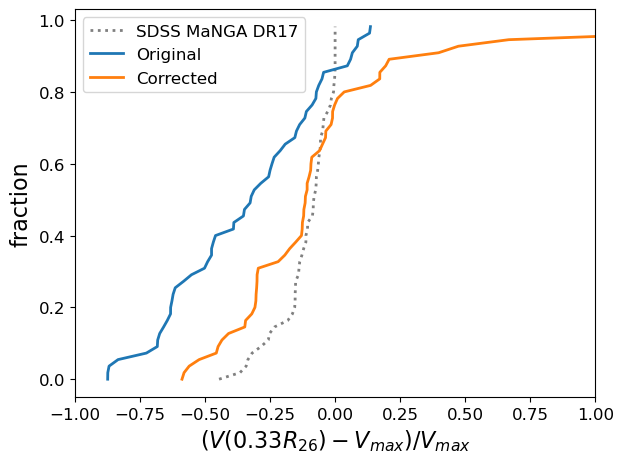

In [105]:
original_x = sorted((SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
DESI_y = np.arange(np.sum(final_sample))/np.sum(final_sample)

corrected_x = sorted(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample])

finite_boolean = np.isfinite(SGA_MaNGA['Vfit_0p33R26'] - SGA_MaNGA['Vmax_map'])
MaNGA_x = sorted((SGA_MaNGA['Vfit_0p33R26'][finite_boolean & final_sample] - SGA_MaNGA['Vmax_map'][finite_boolean & final_sample])/SGA_MaNGA['Vmax_map'][finite_boolean & final_sample])
MaNGA_y = np.arange(np.sum(finite_boolean & final_sample))/np.sum(finite_boolean & final_sample)


plt.figure(tight_layout=True)

plt.plot(MaNGA_x, MaNGA_y, ':', c='gray', linewidth=2, label='SDSS MaNGA DR17')
plt.plot(original_x, DESI_y, c='tab:blue', linewidth=2, label='Original')
plt.plot(corrected_x, DESI_y, c='tab:orange', linewidth=2, label='Corrected')

plt.xlim([-1, 1])

plt.legend()

plt.xlabel('$(V(0.33R_{26}) - V_{max})/V_{max}$', fontsize=16)
plt.ylabel('fraction', fontsize=16);

## How do these residuals depend on the difference in $\phi$?

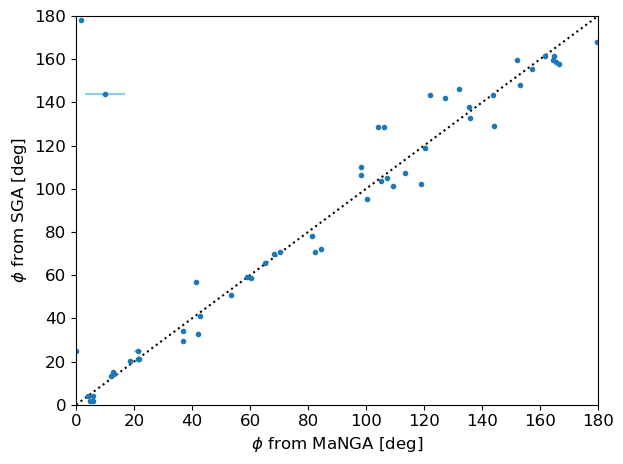

In [106]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_MaNGA['phi_map'][final_sample]%180., SGA_MaNGA['PA'][final_sample], 
             xerr=SGA_MaNGA['phi_err_map'][final_sample], 
             fmt='.', 
             ecolor='lightskyblue')
plt.plot([0,180], [0,180], 'k:')

plt.xlim([0, 180])
plt.ylim([0, 180])

plt.xlabel('$\phi$ from MaNGA [deg]')
plt.ylabel('$\phi$ from SGA [deg]');

In [107]:
SGA_MaNGA['delta_phi'] = SGA_MaNGA['phi_map']%180. - SGA_MaNGA['PA']

SGA_MaNGA['delta_phi'][np.abs(SGA_MaNGA['delta_phi']) >= 90.] = 180. - np.abs(SGA_MaNGA['delta_phi'][np.abs(SGA_MaNGA['delta_phi']) >= 90.])

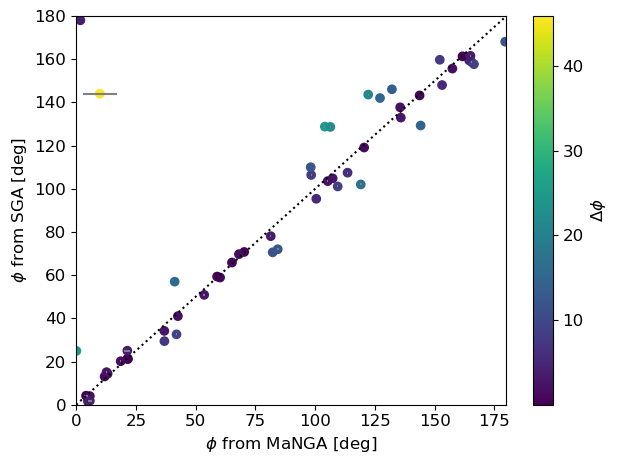

In [108]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_MaNGA['phi_map'][final_sample]%180., SGA_MaNGA['PA'][final_sample], 
             xerr=SGA_MaNGA['phi_err_map'][final_sample], 
             fmt='None',
             ecolor='gray')
plt.scatter(SGA_MaNGA['phi_map'][final_sample]%180., SGA_MaNGA['PA'][final_sample], 
            c=np.abs(SGA_MaNGA['delta_phi'][final_sample]))
plt.plot([0,180], [0,180], 'k:')

plt.xlim([0, 180])
plt.ylim([0, 180])

plt.colorbar(label='$\Delta \phi$')

plt.xlabel('$\phi$ from MaNGA [deg]')
plt.ylabel('$\phi$ from SGA [deg]');

In [109]:
SGA_MaNGA[['plate', 'ifudsgn', 'plateifu', 'SGA_ID', 'BA', 'PA', 'ba_map', 'phi_map', 'delta_phi']][final_sample & (np.abs(SGA_MaNGA['delta_phi']) > 10)]

plate,ifudsgn,plateifu,SGA_ID,BA,PA,ba_map,phi_map,delta_phi
int64,int64,str11,int64,float64,float64,float64,float64,float64
9876,3702,9876-3702,1144453,0.6177683472633362,143.6058807373047,0.4050657323906771,122.17659193855417,-21.42928879875052
11939,6101,11939-6101,302524,0.8450018167495728,168.1051788330078,0.930269490749498,179.4791897776777,11.374010944669891
11939,3701,11939-3701,1274171,0.8015817403793335,24.9233341217041,0.7755550585801662,0.09583912904219045,-24.82749499266191
8547,6102,8547-6102,925354,0.6025776267051697,146.05860900878906,0.8909203195815153,312.0975140458738,-13.96109496291524
11866,12703,11866-12703,1176247,0.7389072179794312,109.9643783569336,0.6630998283519791,278.1196491906676,-11.844729166266006
9862,9101,9862-9101,908303,0.7237770557403564,56.98896026611328,0.9545587264055999,41.20837206502226,-15.780588201091021
8561,3703,8561-3703,560337,0.5461578369140625,102.00253295898438,0.9171706609644817,119.06138599918613,17.058853040201754
10845,12704,10845-12704,196470,0.8195497393608093,142.01385498046875,0.8911240503147498,307.11606393204664,-14.897791048422107
11009,3703,11009-3703,837120,0.8696763515472412,144.04486083984375,0.9586089976305099,189.90273347049606,45.85787263065231


In [110]:
np.std(SGA_MaNGA['delta_phi'][final_sample])

11.046436867868692

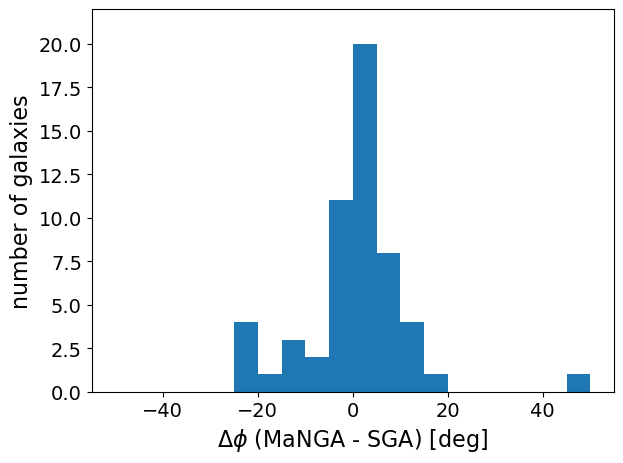

In [114]:
plt.figure(tight_layout=True)

plt.hist(SGA_MaNGA['delta_phi'][final_sample], 
         bins=np.arange(-70, 70, 5))

plt.xlim([-55, 55])
plt.ylim([0, 22])

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$\Delta \phi$ (MaNGA - SGA) [deg]', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

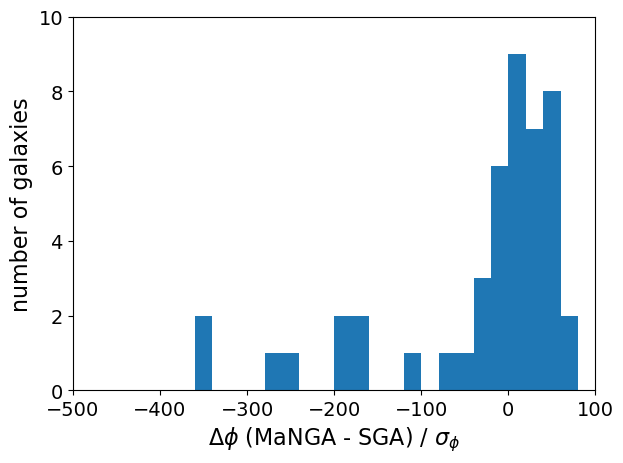

In [117]:
plt.figure(tight_layout=True)

plt.hist(SGA_MaNGA['delta_phi'][final_sample]/SGA_MaNGA['phi_err_map'][final_sample], 
         bins=np.arange(-500, 100, 20))

plt.xlim([-500, 100])
plt.ylim([0, 10])

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$\Delta \phi$ (MaNGA - SGA) / $\sigma_\phi$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

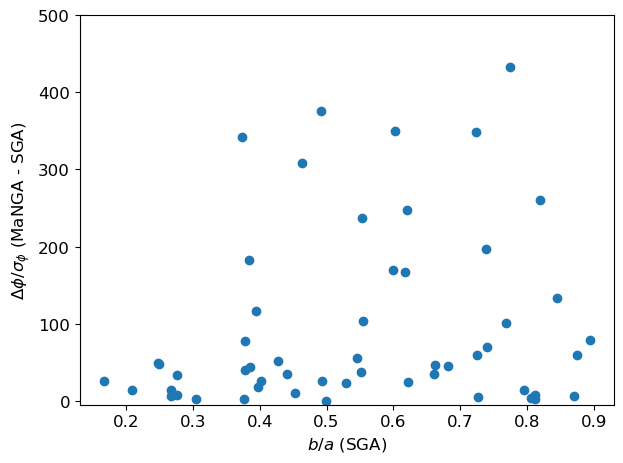

In [118]:
plt.figure(tight_layout=True)

plt.plot(SGA_MaNGA['BA'][final_sample], 
         np.abs(SGA_MaNGA['delta_phi'][final_sample])/SGA_MaNGA['phi_err_map'][final_sample], 
         'o')

plt.ylim([-5, 500])

plt.xlabel('$b/a$ (SGA)')
plt.ylabel('$\Delta \phi / \sigma_\phi$ (MaNGA - SGA)');

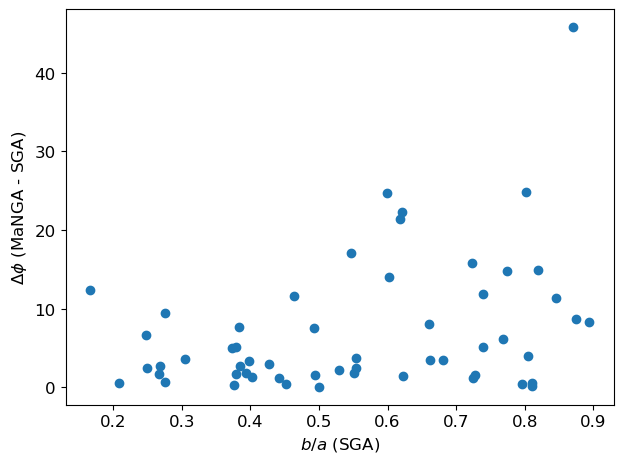

In [119]:
plt.figure(tight_layout=True)

plt.plot(SGA_MaNGA['BA'][final_sample], 
         np.abs(SGA_MaNGA['delta_phi'][final_sample]), 
         'o')

# plt.ylim([-500, 500])

plt.xlabel('$b/a$ (SGA)')
plt.ylabel('$\Delta \phi$ (MaNGA - SGA)');

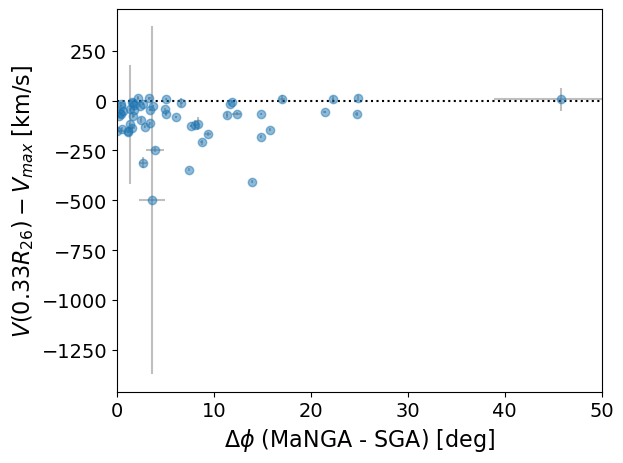

In [120]:
plt.figure(tight_layout=True)

plt.errorbar(np.abs(SGA_MaNGA['delta_phi'][final_sample]), 
             SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['phi_err_map'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray')
plt.hlines(0, 0., 90., linestyles='dotted', colors='k')

plt.xlim(0, 50)
#plt.ylim(-325, 75)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$\Delta \phi$ (MaNGA - SGA) [deg]', fontsize=16)
plt.ylabel('$V(0.33R_{26}) - V_{max}$ [km/s]', fontsize=16);

#plt.savefig('../Figures/SV/MaNGA_fuji_deltaVmax-vs-deltaPhi_20230823.png', dpi=150);

/tmp/ipykernel_759573/1662060378.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('../../Figures/MaNGA_dr17/MaNGA_fuji_deltaV0p33R26-vs-deltaPhi_wHist_20250523.png',


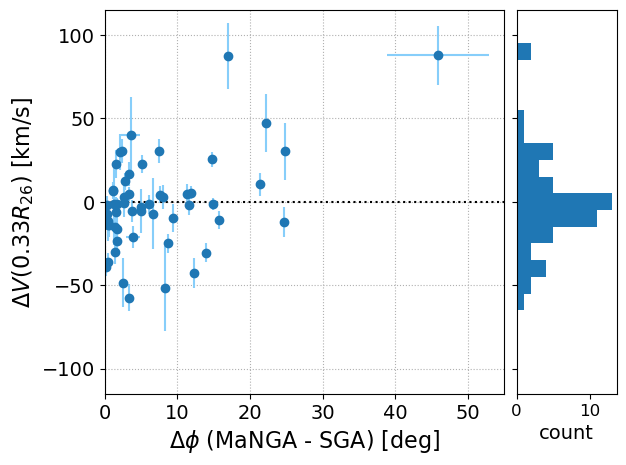

In [137]:
# NOTE: Later cells need to be run before this one!!!

fig = plt.figure(tight_layout=True)

gs = fig.add_gridspec(1, 2, width_ratios=(4, 1), left=0.15, right=0.95, bottom=0.15, top=0.95, wspace=0.05)

ax = fig.add_subplot(gs[0, 0])
ax.errorbar(np.abs(SGA_MaNGA['delta_phi'][final_sample]), 
            SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vfit_corr_0p33R26'][final_sample],#(np.sin(np.arccos(np.sqrt(cosi2_manga[final_sample])))/np.sin(np.arccos(np.sqrt(cosi2_sga[final_sample]))))*SGA_MaNGA['Vfit_0p33R26'][final_sample], 
            xerr=SGA_MaNGA['phi_err_map'][final_sample], 
            yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vfit_corr_0p33R26_err'][final_sample]**2), 
            fmt='o', 
            # alpha=0.5,
            ecolor='lightskyblue')
ax.hlines(0, 0., 90., linestyles='dotted', colors='k')

ax.grid(ls=':')

ax.set_xlim(0, 55)
ax.set_ylim(-115, 115)

plt.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlabel('$\Delta \phi$ (MaNGA - SGA) [deg]', fontsize=16)
ax.set_ylabel('$\Delta V(0.33R_{26})$ [km/s]', fontsize=16)


ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)
ax_histy.hist(SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vfit_corr_0p33R26'][final_sample], 
              bins=np.arange(-115, 115, 10), 
              orientation='horizontal')

ax_histy.tick_params(axis='y', labelleft=False)

ax_histy.set_xlabel('count', fontsize=14);

# plt.savefig('../../Figures/MaNGA_dr17/MaNGA_fuji_deltaV0p33R26-vs-deltaPhi_20240228.png', dpi=150);
plt.savefig('../../Figures/MaNGA_dr17/MaNGA_fuji_deltaV0p33R26-vs-deltaPhi_wHist_20250523.png', 
            dpi=150, 
            facecolor='None');

In [139]:
SGA_MaNGA[(np.abs(SGA_MaNGA['V_0p33R26'] - SGA_MaNGA['Vfit_corr_0p33R26']) > 75) & final_sample]

plate,ifudsgn,plateifu,SGA_ID,Z_DESI,ZERR_DESI,R26,BA,PA,V_0p33R26,V_0p33R26_ERR,SKY_FIBER_DIST,Vmax_map,Vmax_err_map,Rturn_map,alpha_map,ba_map,ba_err_map,ba_NSA,phi_map,phi_err_map,phi_NSA,Z_NSA,Vfit_R26,Vfit_0p33R26,Vfit_0p4R26,delta_phi,Vfit_0p33R26_err,Vfit_corr_0p33R26,Vfit_corr_0p33R26_err,i_map
int64,int64,str11,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8561,3703,8561-3703,560337,0.0299296308939717,1.29844884480755e-06,0.32551541924476624,0.5461578369140625,102.00253295898438,129.76401735155142,19.66577876716321,3.124723882399848e-05,121.70306232503773,2.9753463797203836,2.192716862874739,1.8541013123189807,0.9171706609644817,0.003952647205960103,0.623194,119.06138599918613,0.30948537310652174,100.574,0.0299286,116.68710301352569,93.38746935588264,99.83217166374729,17.058853040201754,2.6082616359347424,42.470897413402824,1.2823345435729672,0.418851924546907
11009,3703,11009-3703,837120,0.02673584822357,4.0670771610716e-06,0.27344420552253723,0.8696763515472412,144.04486083984375,142.5600977825115,14.031469607078616,2.6248757886358743e-05,136.17387888750457,55.957450018226204,1.1025243058665049,29.40636840351816,0.9586089976305099,0.03694269646770102,0.8807298,189.90273347049606,6.9937903305260525,140.63043,0.026740992,136.1738788875046,136.1738788616112,136.17387888741465,45.85787263065231,25.857821519276847,54.702844948515754,10.722395373024504,0.294850774850321


##### Is there a correlation between $\Delta \phi$ and redshift?

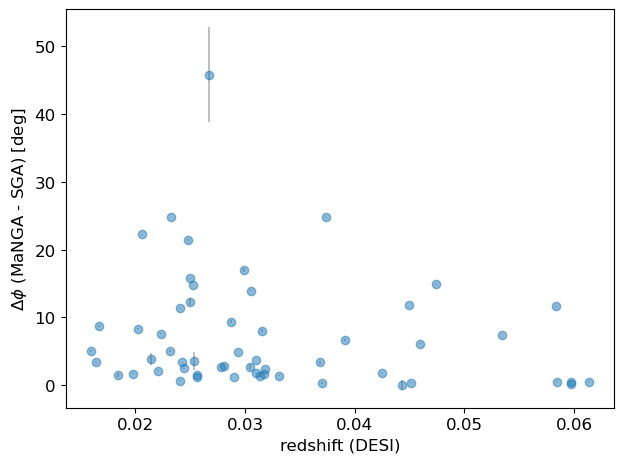

In [140]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             np.abs(SGA_MaNGA['delta_phi'][final_sample]), 
             yerr=SGA_MaNGA['phi_err_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             fmt='o', 
             alpha=0.5,
             ecolor='gray')
# plt.hlines(0, 0, 0.1, linestyles='dotted', colors='k')

#plt.ylim(0, 60)
#plt.xlim(0.01, 0.08)

plt.ylabel('$\Delta \phi$ (MaNGA - SGA) [deg]')
plt.xlabel('redshift (DESI)');

#### Save figure data to file for DESI publication

In [60]:
plot_v033 = fits.Column(name='DESI_V', array=SGA_MaNGA['V_0p33R26'], format='E', unit='km/s')
plot_v033_sigma = fits.Column(name='DESI_Verr', array=SGA_MaNGA['V_0p33R26_ERR'], format='E', unit='km/s')

plot_vmax = fits.Column(name='MaNGA_Vmax', array=SGA_MaNGA['Vmax_map'], format='E', unit='km/s')
plot_vmax_sigma = fits.Column(name='MaNGA_Vmax_err', array=SGA_MaNGA['Vmax_err_map'], format='E', unit='km/s')

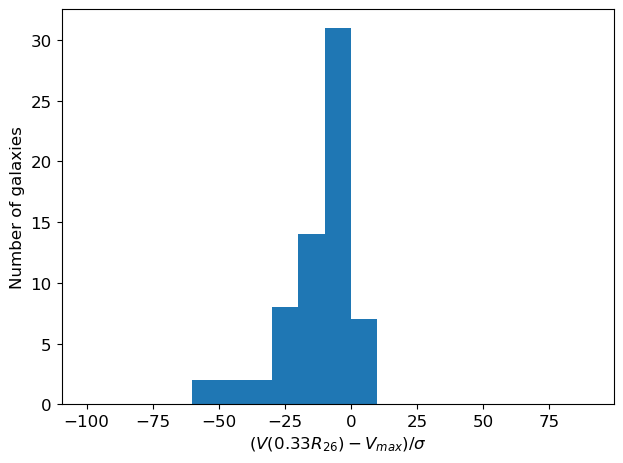

In [142]:
plt.figure(tight_layout=True)

plt.hist((SGA_MaNGA['V_0p33R26'] - SGA_MaNGA['Vmax_map'])/np.sqrt(SGA_MaNGA['V_0p33R26_ERR']**2 + SGA_MaNGA['Vmax_err_map']**2), 
         #bins=np.arange(-500, 100, 50), 
         bins=np.arange(-100, 100, 10),
         #histtype='step', 
         #linewidth=3
        )

#plt.xlabel('($V(0.33R_{26}) - V_{max}$) [km/s]')
plt.xlabel('($V(0.33R_{26}) - V_{max}$)/$\sigma$')
plt.ylabel('Number of galaxies');

#plt.savefig('../Figures/SV/fuji_MaNGA_Vmax_pull.png', dpi=300);

## How do these residuals depend on the inclination angle?

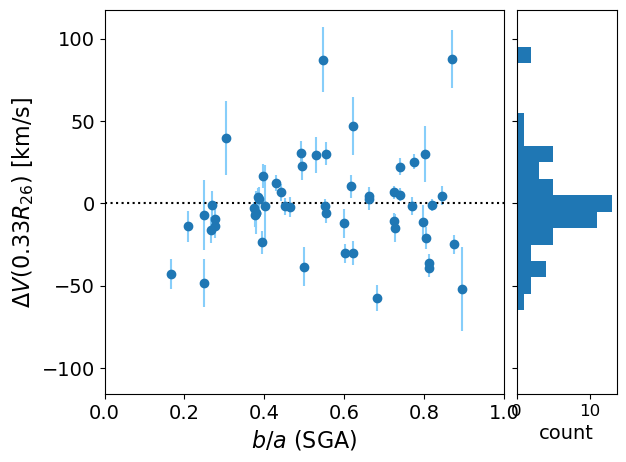

In [143]:
# NOTE: Later cells need to be run before this one!!!

fig = plt.figure(tight_layout=True)

gs = fig.add_gridspec(1, 2, width_ratios=(4, 1), left=0.15, right=0.95, bottom=0.15, top=0.95, wspace=0.05)

ax = fig.add_subplot(gs[0, 0])
ax.errorbar(SGA_MaNGA['BA'][final_sample], 
            SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vfit_corr_0p33R26'][final_sample],
            yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vfit_corr_0p33R26_err'][final_sample]**2), 
            fmt='o', 
            # alpha=0.5,
            ecolor='lightskyblue')
ax.hlines(0, 0., 90., linestyles='dotted', colors='k')

ax.set_xlim(0, 1)
#plt.ylim(-325, 75)

plt.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlabel('$b/a$ (SGA)', fontsize=16)
ax.set_ylabel('$\Delta V(0.33R_{26})$ [km/s]', fontsize=16)


ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)
ax_histy.hist(SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vfit_corr_0p33R26'][final_sample], 
              bins=np.arange(-105, 105, 10), 
              orientation='horizontal')

ax_histy.set_xlabel('count', fontsize=14)
ax_histy.tick_params(axis='y', labelleft=False);

# plt.savefig('../../Figures/MaNGA_dr17/MaNGA_fuji_deltaV0p33R26-vs-ba_wHist_20241213.png', dpi=150, facecolor='none');

# Compare DESI's observed rotational velocities at 0.33$R_{26}$ with $V(0.33R_{26})$ from the best-fit to MaNGA

### 1) Convert $R_{26}$ to kpc for each galaxy

In [126]:
dist_to_galaxy = SGA_MaNGA['Z_DESI']*c/H0

p33R26_kpc = dist_to_galaxy.to('kpc')*np.tan(SGA_MaNGA['SKY_FIBER_DIST'])

### 2) Compute $V(0.33R_{26})$ based on the best-fits

In [127]:
SGA_MaNGA['Vfit_0p33R26'] = rot_fit_BB(p33R26_kpc.data, 
                                       [SGA_MaNGA['Vmax_map'], 
                                        SGA_MaNGA['Rturn_map'], 
                                        SGA_MaNGA['alpha_map']])

#### Compute the uncertainty in the velocity at this location

In [128]:
SGA_MaNGA['Vfit_0p33R26_err'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    if np.isfinite(SGA_MaNGA['Vmax_map'][i]) and np.isfinite(SGA_MaNGA['V_0p33R26'][i]):
        
        gal_ID = str(SGA_MaNGA['plate'][i]) + '-' + str(SGA_MaNGA['ifudsgn'][i])

        try:
            Hessian = np.load('/global/u1/k/kadglass/RotationCurves/spirals/DRP_map_Hessians/dr17/' + gal_ID + '_Hessian.npy')
            hess_inv = 2*np.linalg.inv(Hessian)

            N_samples = 10000

            random_sample = np.random.multivariate_normal(mean=[SGA_MaNGA['Vmax_map'][i], 
                                                                SGA_MaNGA['Rturn_map'][i], 
                                                                SGA_MaNGA['alpha_map'][i]], 
                                                          cov=hess_inv[-3:,-3:], 
                                                          size=N_samples)

            # Remove bad samples (those with negative values for any of the parameters)
            is_good_random = (random_sample[:,0] > 0) & (random_sample[:,1] > 0) & (random_sample[:,2] > 0)
            good_randoms = random_sample[is_good_random, :]

            # Calculate values of curve at this location
            y_sample = rot_fit_BB(R26_kpc[i].value, [good_randoms[:,0], 
                                                     good_randoms[:,1], 
                                                     good_randoms[:,2]])

            SGA_MaNGA['Vfit_0p33R26_err'][i] = np.std(y_sample, axis=0)
        except (FileNotFoundError, np.linalg.LinAlgError) as error:
            print(gal_ID, error)

/tmp/ipykernel_759573/4257422339.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[SGA_MaNGA['Vmax_map'][i],
/global/homes/k/kadglass/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in power
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


### 3) Plot

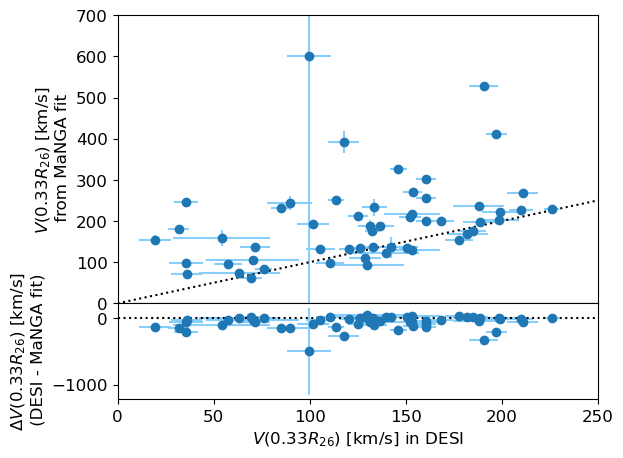

In [144]:
fig = plt.figure()

frame1 = fig.add_axes((0.2, 0.35, 0.75, 0.6))

plt.errorbar(SGA_MaNGA['V_0p33R26'][final_sample], SGA_MaNGA['Vfit_0p33R26'][final_sample], 
             yerr=SGA_MaNGA['Vfit_0p33R26_err'][final_sample], 
             xerr=SGA_MaNGA['V_0p33R26_ERR'][final_sample], 
             fmt='o', 
             ecolor='lightskyblue')
plt.plot([0, 1000], [0, 1000], 'k:')

plt.ylim(0, 700)
plt.xlim(0, 250)

plt.ylabel('$V(0.33R_{26})$ [km/s]\n from MaNGA fit')

frame1.axes.get_xaxis().set_visible(False)


frame2 = fig.add_axes((0.2, 0.15, 0.75, 0.2))

plt.errorbar(SGA_MaNGA['V_0p33R26'][final_sample], SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vfit_0p33R26'][final_sample], 
             xerr=SGA_MaNGA['V_0p33R26_ERR'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vfit_0p33R26_err'][final_sample]**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 250, linestyles='dotted', colors='k')

plt.xlim(0, 250)

plt.xlabel('$V(0.33R_{26})$ [km/s] in DESI')
plt.ylabel('$\Delta V(0.33R_{26})$ [km/s]\n (DESI - MaNGA fit)');

#plt.savefig('../Figures/SV/fuji_MaNGA-V0p33_comparison.eps', dpi=300);

#### Write plot data to file for DESI publication

In [72]:
plot_v033_fit = fits.Column(name='MaNGA_Vfit', array=SGA_MaNGA['Vfit_0p33R26'], format='E', unit='km/s')
plot_v033_fit_sigma = fits.Column(name='MaNGA_Vfit_err', array=SGA_MaNGA['Vfit_0p33R26_err'], format='E', unit='km/s')

In [73]:
plot_table = fits.BinTableHDU.from_columns([plot_v033, plot_v033_sigma, plot_v033_fit, plot_v033_fit_sigma, plot_vmax, plot_vmax_sigma])

if not os.path.exists('publication_data'):
    os.makedirs('publication_data')

plot_table.writeto('publication_data/figs10-11.fits', overwrite=True)

### Pull distribution

In [130]:
diff_norm = (SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vfit_0p33R26'][final_sample])/np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vfit_0p33R26_err'][final_sample]**2)

avg = np.nanmean(diff_norm)

std_dev = np.nanstd(diff_norm)

print(avg, std_dev)

-6.344726622945466 8.443581445384481


In [131]:
# Segev: Normalize Gaussian by area under the curve (to figure out what the amplitude should be)
# The area is equal to the number of galaxies, so 
area = np.sum(np.isfinite(SGA_MaNGA['Vmax_map'][final_sample]) & np.isfinite(SGA_MaNGA['V_0p33R26'][final_sample]))

#amplitude = area/(std_dev*np.sqrt(2*np.pi))
# scipy.stats.norm.pdf is already normalized by sigma and the sqrt of 2pi, so we just need to scale it by the area.

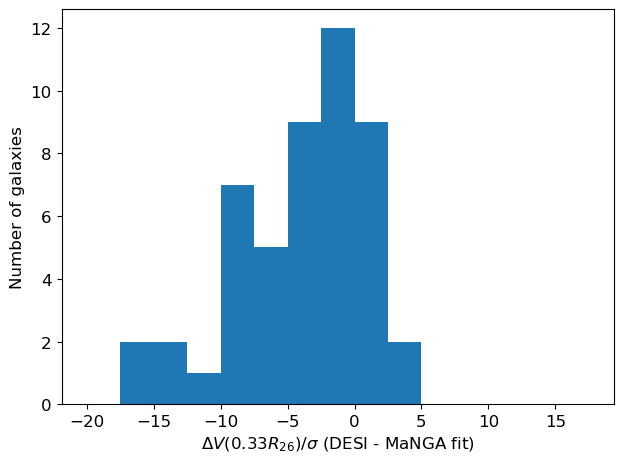

In [132]:
plt.figure(tight_layout=True)

plt.hist(diff_norm, 
         #bins=np.arange(-400, 100, 50), 
         bins=np.arange(-20, 20, 2.5), 
         #density=True
        )
'''
x = np.arange(-9, 9, 0.1)
plt.plot(x, area*stats.norm.pdf(x, avg, std_dev))

plt.annotate('$\mu$ = {0:.2f}\n$\sigma$ = {1:.2f}'.format(avg, std_dev), 
             (6, 14))

plt.xlim((-9, 9))
'''
#plt.xlabel('$\Delta V(0.33R_{26})$ [km/s] (DESI - MaNGA fit)')
plt.xlabel('$\Delta V(0.33R_{26})/\sigma$ (DESI - MaNGA fit)')
plt.ylabel('Number of galaxies');

#plt.savefig('../Figures/SV/fuji_MaNGA_V0p33_pull.png', dpi=300);

## Repeat with correcting for differences in $i$ and $\phi$ between MaNGA fits and SGA values

In [133]:
delta_pa = np.abs((SGA_MaNGA['phi_map']%180.) - SGA_MaNGA['PA'])
delta_pa[delta_pa > 90.] = 180. - delta_pa[delta_pa > 90.]
SGA_MaNGA['delta_phi'] = delta_pa

cosi2_sga = (SGA_MaNGA['BA']**2 - q0**2)/(1 - q0**2)
cosi2_manga = (SGA_MaNGA['ba_map']**2 - q0**2)/(1 - q0**2)

cosi2_sga[cosi2_sga < 0] = 0.
cosi2_manga[cosi2_manga < 0] = 0.

DESI_corrected = (1./np.cos(delta_pa*np.pi/180.))*(np.sin(np.arccos(np.sqrt(cosi2_sga)))/np.sin(np.arccos(np.sqrt(cosi2_manga))))*SGA_MaNGA['V_0p33R26']

SGA_MaNGA['Vfit_corr_0p33R26'] = np.cos(delta_pa*np.pi/180.)*(np.sin(np.arccos(np.sqrt(cosi2_manga)))/np.sin(np.arccos(np.sqrt(cosi2_sga))))*SGA_MaNGA['Vfit_0p33R26']

/tmp/ipykernel_759573/668929969.py:13: RuntimeWarning: divide by zero encountered in true_divide
  SGA_MaNGA['Vfit_corr_0p33R26'] = np.cos(delta_pa*np.pi/180.)*(np.sin(np.arccos(np.sqrt(cosi2_manga)))/np.sin(np.arccos(np.sqrt(cosi2_sga))))*SGA_MaNGA['Vfit_0p33R26']


### Calculate the uncertainty in the adjusted MaNGA fit value

In [134]:
SGA_MaNGA['Vfit_corr_0p33R26_err'] = np.nan

# Convert b/a to i (to match what is in the Hessians)
SGA_MaNGA['i_map'] = np.arccos(np.sqrt((SGA_MaNGA['ba_map']**2 - q0**2)/(1 - q0**2)))

for i in range(len(SGA_MaNGA)):
    
    if np.isfinite(SGA_MaNGA['Vmax_map'][i]) and np.isfinite(SGA_MaNGA['V_0p33R26'][i]):
        
        gal_ID = str(SGA_MaNGA['plate'][i]) + '-' + str(SGA_MaNGA['ifudsgn'][i])

        try:
            Hessian = np.load('/global/u1/k/kadglass/RotationCurves/spirals/DRP_map_Hessians/dr17/' + gal_ID + '_Hessian.npy')
            hess_inv_all = 2*np.linalg.inv(Hessian)
            
            # Reconstruct the inverse Hessian to contain just the parameters that we need
            hess_inv = np.zeros((5,5))
            hess_inv[-4:,-4:] = hess_inv_all[-4:,-4:] # copies phi, Vmax, Rturn, and alpha
            hess_inv[0,0] = hess_inv_all[1,1] # copies i
            hess_inv[0,-4:] = hess_inv_all[1,-4:] # copies off-diagonal elements for i
            hess_inv[-4:,0] = hess_inv_all[-4:,1] # copies off-diagonal elements for i

            N_samples = 10000

            random_sample = np.random.multivariate_normal(mean=[SGA_MaNGA['i_map'][i],
                                                                SGA_MaNGA['phi_map'][i], 
                                                                SGA_MaNGA['Vmax_map'][i], 
                                                                SGA_MaNGA['Rturn_map'][i], 
                                                                SGA_MaNGA['alpha_map'][i]], 
                                                          cov=hess_inv, 
                                                          size=N_samples)

            # Remove bad samples (those with negative values for any of the parameters)
            is_good_random = np.all(random_sample > 0, axis=1)
            good_randoms = random_sample[is_good_random, :]

            # Calculate values of curve at this location
            y_sample = rot_fit_BB(R26_kpc[i].value, [good_randoms[:,-3], 
                                                     good_randoms[:,-2], 
                                                     good_randoms[:,-1]])
            
            # Adjust for differences in i and phi
            delta_pa_sample = np.abs((good_randoms[:,1]%180.) - SGA_MaNGA['PA'][i])
            delta_pa_sample[delta_pa_sample > 90.] = 180. - delta_pa_sample[delta_pa_sample > 90.]
            
            y_sample = np.cos(delta_pa_sample*np.pi/180)*(np.sin(good_randoms[:,0])/np.sin(np.arccos(np.sqrt(cosi2_sga[i]))))*y_sample

            SGA_MaNGA['Vfit_corr_0p33R26_err'][i] = np.std(y_sample, axis=0)
            
        except (FileNotFoundError, np.linalg.LinAlgError) as error:
            print(gal_ID, error)

/tmp/ipykernel_759573/2356790086.py:25: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[SGA_MaNGA['i_map'][i],
/global/homes/k/kadglass/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in power
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


### Plot

/tmp/ipykernel_759573/274145273.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_comparison_corrected_20250523.png',


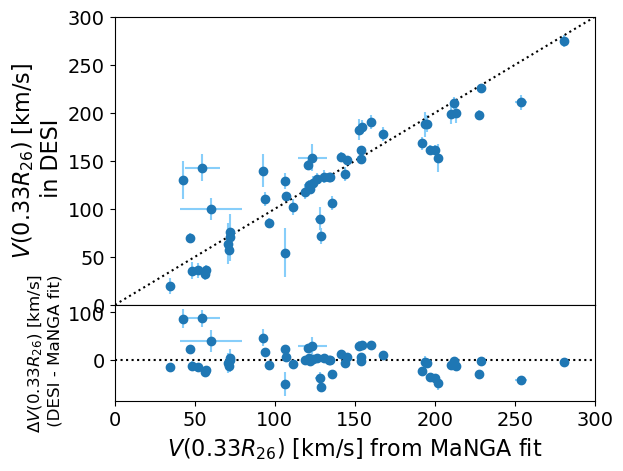

In [149]:
fig = plt.figure(tight_layout=True)

frame1 = fig.add_axes((0.2, 0.35, 0.75, 0.6))

plt.errorbar(SGA_MaNGA['Vfit_corr_0p33R26'][final_sample], SGA_MaNGA['V_0p33R26'][final_sample], 
             xerr=SGA_MaNGA['Vfit_corr_0p33R26_err'][final_sample], 
             yerr=SGA_MaNGA['V_0p33R26_ERR'][final_sample], 
             fmt='o', 
             ecolor='lightskyblue')
plt.plot([0, 1000], [0, 1000], 'k:')

plt.xlim(0, 300)
plt.ylim(0, 300)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.ylabel('$V(0.33R_{26})$ [km/s]\n in DESI', fontsize=16)

frame1.axes.get_xaxis().set_visible(False)


frame2 = fig.add_axes((0.2, 0.15, 0.75, 0.2))

plt.errorbar(SGA_MaNGA['Vfit_corr_0p33R26'][final_sample], SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vfit_corr_0p33R26'][final_sample], 
             xerr=SGA_MaNGA['Vfit_corr_0p33R26_err'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR'][final_sample]**2 + SGA_MaNGA['Vfit_corr_0p33R26_err'][final_sample]**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 350, linestyles='dotted', colors='k')

plt.xlim(0, 300)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$V(0.33R_{26})$ [km/s] from MaNGA fit', fontsize=16)
plt.ylabel('$\Delta V(0.33R_{26})$ [km/s]\n (DESI - MaNGA fit)');

plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_comparison_corrected_20250523.png', 
            dpi=150, 
            facecolor='None');

### Compute the perpendicular distance to $y = x$ for each point

See Segev's notebook, `line_hist.ipynb`, for the calculation.

In [150]:
dist = (SGA_MaNGA['V_0p33R26'] - SGA_MaNGA['Vfit_corr_0p33R26']) / np.sqrt(2)

In [151]:
# Normalize these distances by the "expected" value at y = x
dist_norm = dist / (0.5*(SGA_MaNGA['V_0p33R26'] + SGA_MaNGA['Vfit_corr_0p33R26']))

# Normalize these distances by the "total" uncertainty
dist_norm_sigma = dist / np.sqrt(SGA_MaNGA['Vfit_corr_0p33R26_err']**2 + SGA_MaNGA['V_0p33R26_ERR']**2)

In [152]:
sigma_dist = np.std(dist[final_sample])
sigma_dist_norm = np.std(dist_norm[final_sample])
sigma_dist_norm_sigma = np.std(dist_norm_sigma[final_sample])

print(sigma_dist)
print(sigma_dist_norm)
print(sigma_dist_norm_sigma)

20.14290867523713
0.21174788030187736
2.0842613875623566


#### Plot

##### Distribution of perpendicular distances

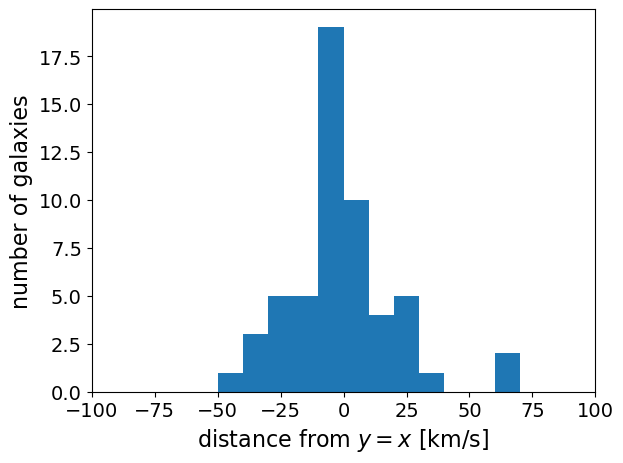

In [153]:
plt.figure(tight_layout=True)

plt.hist(dist[final_sample], bins=np.arange(-80, 110, 10))

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim(-100, 100)

plt.xlabel('distance from $y = x$ [km/s]', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_diff_hist.eps', dpi=150);

##### Distribution of perpendicular distances normalized by $V$

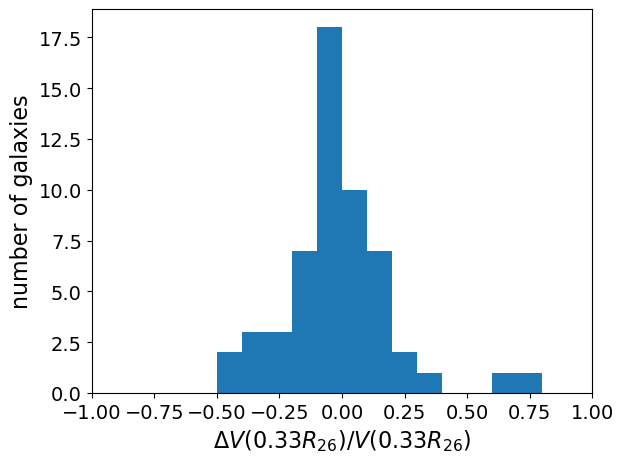

In [154]:
plt.figure(tight_layout=True)

plt.hist(dist_norm[final_sample], bins=np.arange(-0.5, 1.25, 0.1))

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim([-1, 1])

plt.xlabel('$\Delta V(0.33R_{26}) / V(0.33R_{26})$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_diffnorm_hist.eps', dpi=150);

##### Distribution of perpendicular distances normalized by $\sigma$

\begin{equation}
  \sigma^2 = \sigma_\text{DESI}^2 + \sigma_\text{MaNGA}^2
\end{equation}

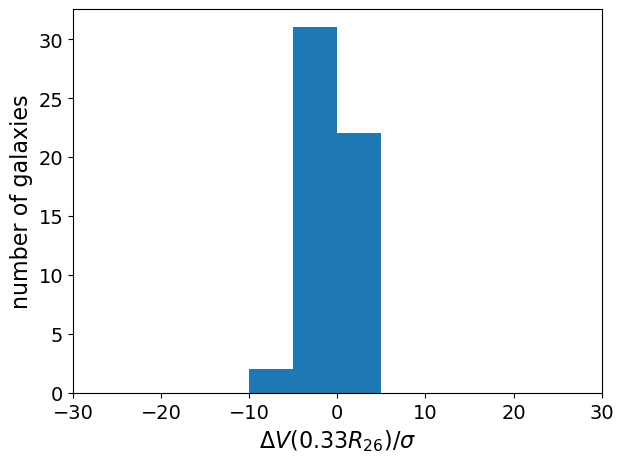

In [155]:
plt.figure(tight_layout=True)

plt.hist(dist_norm_sigma[final_sample], bins=np.arange(-30, 30, 5))

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim([-30, 30])

plt.xlabel('$\Delta V(0.33R_{26}) / \sigma$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_diffnormsigma_hist.eps', dpi=150);

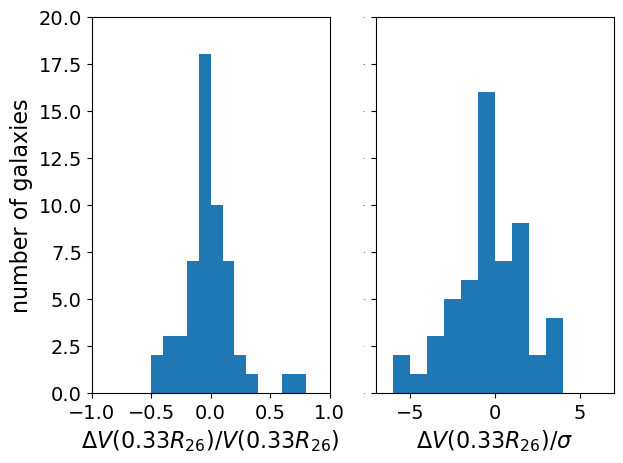

In [167]:
plt.figure(tight_layout=True)


plt.subplot(121)

plt.hist(dist_norm[final_sample], bins=np.arange(-0.5, 1.25, 0.1))

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim([-1, 1])
plt.ylim([0, 20])

plt.xlabel('$\Delta V(0.33R_{26}) / V(0.33R_{26})$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16)


plt.subplot(122)

plt.hist(dist_norm_sigma[final_sample], bins=np.arange(-10, 10, 1))

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='y', labelsize=0)

plt.xlim([-7, 7])
plt.ylim([0, 20])

plt.xlabel('$\Delta V(0.33R_{26}) / \sigma$', fontsize=16);

plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_diffnorm-sigma-dVsys_hists_20250523.png', 
            dpi=150, 
            facecolor='None');

# Compare DESI's observed rotational velocities at $0.33R_{26}$ with the velocity observed in MaNGA

To do this, we need to extract the observed redshifts at the center and at the location of the fiber from the MaNGA H$\alpha$ maps.

In [44]:
MANGA_FOLDER = '/global/cfs/cdirs/sdss/data/sdss/dr17/manga/spectro/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v3_1_1/3.1.0/HYB10-MILESHC-MASTARSSP/'

# Index of Ha map
# map_idx = 18
map_idx = 23

# hdul = fits.open(VEL_MAP_FOLDER + '7443/12705/manga-7443-12705-MAPS-HYB10-GAU-MILESHC.fits.gz')
# vel = hdul['EMLINE_GVEL']
# hdul.close()

In [94]:
VI_axis_0p3_good['V_MaNGA'] = np.nan
VI_axis_0p3_good['V_MaNGA_IVAR'] = np.nan

for i in range(len(VI_axis_0p3_good)):
    
    gal_row = SGA_MaNGA['SGA_ID'] == VI_axis_0p3_good['SGA_ID'][i]
    
    if np.sum(gal_row) > 0:
        
        # Find galaxy's MaNGA plate-IFU
        gal_plate = SGA_MaNGA['plate'][gal_row][0]
        gal_IFU = SGA_MaNGA['ifudsgn'][gal_row][0]


        ##################################################################################
        # Import data file
        #---------------------------------------------------------------------------------
        # file_name = str(gal_plate) + '/' + str(gal_IFU) + '/manga-' + str(gal_plate) + '-' + str(gal_IFU) + '-MAPS-HYB10-GAU-MILESHC.fits.gz'
        file_name = str(gal_plate) + '/' + str(gal_IFU) + '/manga-' + str(gal_plate) + '-' + str(gal_IFU) + '-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz'
        # print(VEL_MAP_FOLDER + file_name)

        if os.path.isfile(VEL_MAP_FOLDER + file_name):
            # print('Data file exists!')
            hdul = fits.open(VEL_MAP_FOLDER + file_name)
            # cz = hdul['PRIMARY'].header['SCINPVEL']
            vel = hdul['EMLINE_GVEL']

            Ha_vel = vel.data[map_idx]# + cz
            Ha_ivar = hdul['EMLINE_GVEL_IVAR'].data[map_idx]
            Ha_mask = hdul['EMLINE_GVEL_MASK'].data[map_idx]

            mHa_vel = ma.array(Ha_vel, mask=Ha_mask)
            mHa_ivar = ma.array(Ha_ivar, mask=Ha_mask)
            ##################################################################################

            gal_wcs = wcs.WCS(vel.header)
            '''
            ##################################################################################
            plt.figure()

            ax = plt.subplot(projection=gal_wcs, slices=('x', 'y', map_idx))
            vel_im = ax.imshow(mHa_vel, cmap='RdBu_r', origin='lower')

            plt.plot(VI_axis_0p3_good['RA'][i], 
                     VI_axis_0p3_good['DEC'][i], 
                     'gx', 
                     transform=ax.get_transform('world'))

            plt.colorbar(vel_im, ax=ax)
            break
            ##################################################################################
            '''
            # Convert DESI observed coordinates to pixel coordinates
            pix_coords = gal_wcs.wcs_world2pix(np.array([[VI_axis_0p3_good['RA'][i], VI_axis_0p3_good['DEC'][i], map_idx]]), 0)

            #print(axis_0p3_good['RA'][i], axis_0p3_good['DEC'][i])
            #print(pix_coords, pix_coords[0][:2], pix_coords[0][:2].astype(int))

            # Extract observed velocity at that location
            if np.all(pix_coords >= 0) and np.all(pix_coords < mHa_vel.shape[0]):
                # cz_manga = mHa_vel[pix_coords[0][0].astype(int), pix_coords[0][1].astype(int)]
                # cz_manga_ivar = mHa_ivar[pix_coords[0][0].astype(int), pix_coords[0][1].astype(int)]
                v_manga = mHa_vel[pix_coords[0][0].astype(int)-1:pix_coords[0][0].astype(int)+2, 
                                  pix_coords[0][1].astype(int)-1:pix_coords[0][1].astype(int)+2]
                v_manga_ivar = mHa_ivar[pix_coords[0][0].astype(int)-1:pix_coords[0][0].astype(int)+2, 
                                        pix_coords[0][1].astype(int)-1:pix_coords[0][1].astype(int)+2]
                cz_manga = ma.average(v_manga, weights=v_manga_ivar)
                cz_manga_ivar = ma.sum(v_manga_ivar)

                #print(cz_manga)

                # Save this measured velocity
                VI_axis_0p3_good['V_MaNGA'][i] = cz_manga
                VI_axis_0p3_good['V_MaNGA_IVAR'][i] = cz_manga_ivar
            '''
            ##################################################################################
            plt.figure()

            plt.imshow(mHa_vel, cmap='RdBu_r', origin='lower')
            plt.plot(pix_coords[0][0], pix_coords[0][1], 'gx')
            ##################################################################################

            break
            ''';

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/ma/extras.py:623: RuntimeWarning: invalid value encountered in true_divide
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/astropy/table/column.py:1383: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


In [95]:
good_centers['V_MaNGA'] = np.nan
good_centers['V_MaNGA_IVAR'] = np.nan

for i in range(len(good_centers)):
    
    gal_row = SGA_MaNGA['SGA_ID'] == good_centers['SGA_ID'][i]
    
    if np.sum(gal_row) > 0:
        
        # Find galaxy's MaNGA plate-IFU
        gal_plate = SGA_MaNGA['plate'][gal_row][0]
        gal_IFU = SGA_MaNGA['ifudsgn'][gal_row][0]

        ##################################################################################
        # Import data file
        #---------------------------------------------------------------------------------
        file_name = str(gal_plate) + '/' + str(gal_IFU) + '/manga-' + str(gal_plate) + '-' + str(gal_IFU) + '-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz'

        if os.path.isfile(VEL_MAP_FOLDER + file_name):
            hdul = fits.open(VEL_MAP_FOLDER + file_name)
            # cz = hdul['PRIMARY'].header['SCINPVEL']
            vel = hdul['EMLINE_GVEL']

            Ha_vel = vel.data[map_idx] #+ cz
            Ha_ivar = hdul['EMLINE_GVEL_IVAR'].data[map_idx]
            Ha_mask = hdul['EMLINE_GVEL_MASK'].data[map_idx]

            mHa_vel = ma.array(Ha_vel, mask=Ha_mask)
            mHa_ivar = ma.array(Ha_ivar, mask=Ha_mask)
            ##################################################################################

            gal_wcs = wcs.WCS(vel.header)
            
            # Convert DESI observed coordinates to pixel coordinates
            pix_coords = gal_wcs.wcs_world2pix(np.array([[good_centers['RA'][i], 
                                                          good_centers['DEC'][i], 
                                                          map_idx]]), 
                                               0)

            # Extract observed velocity at that location
            if np.all(pix_coords >= 0) and np.all(pix_coords < mHa_vel.shape[0]):
                # cz_manga = mHa_vel[pix_coords[0][0].astype(int), pix_coords[0][1].astype(int)]
                # cz_manga_ivar = mHa_ivar[pix_coords[0][0].astype(int), pix_coords[0][1].astype(int)]
                v_manga = mHa_vel[pix_coords[0][0].astype(int)-1:pix_coords[0][0].astype(int)+2, 
                                  pix_coords[0][1].astype(int)-1:pix_coords[0][1].astype(int)+2]
                v_manga_ivar = mHa_ivar[pix_coords[0][0].astype(int)-1:pix_coords[0][0].astype(int)+2, 
                                        pix_coords[0][1].astype(int)-1:pix_coords[0][1].astype(int)+2]
                cz_manga = ma.average(v_manga, weights=v_manga_ivar)
                cz_manga_ivar = ma.sum(v_manga_ivar)
                
                #print(cz_manga)

                # Save this measured velocity
                good_centers['V_MaNGA'][i] = cz_manga
                good_centers['V_MaNGA_IVAR'][i] = cz_manga_ivar

In [96]:
VI_axis_0p3_good['V_ROT_MaNGA'] = np.nan
VI_axis_0p3_good['V_ROT_MaNGA_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(good_centers['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_axis_0p3_good['SGA_ID'] == sga_gal
    center_idx = good_centers['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average velocity of all center observations for the systemic velocity
    v_center = np.mean(good_centers['V_MaNGA'][center_idx])
    v_err_center2 = np.sum(1./good_centers['V_MaNGA_IVAR'][center_idx])/np.sum(center_idx)**2

    # Calculate rotational velocity for all observations of the galaxy
    VI_axis_0p3_good['V_ROT_MaNGA'][obs_idx] = VI_axis_0p3_good['V_MaNGA'][obs_idx] - v_center
    VI_axis_0p3_good['V_ROT_MaNGA_ERR'][obs_idx] = np.sqrt(1./VI_axis_0p3_good['V_MaNGA_IVAR'][obs_idx] + v_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    VI_axis_0p3_good['V_ROT_MaNGA'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

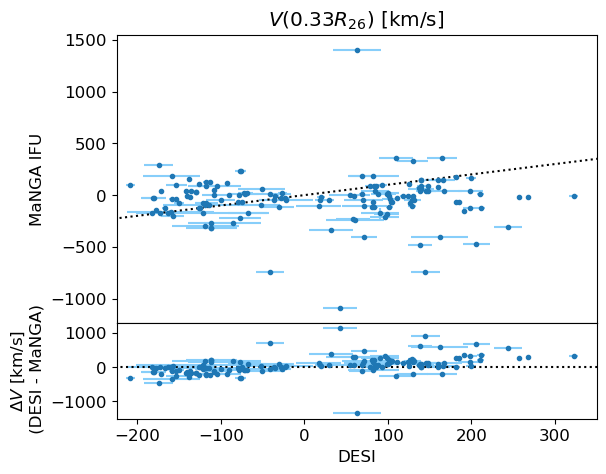

In [97]:
fig = plt.figure()

frame1 = fig.add_axes((0.2, 0.35, 0.75, 0.6))

plt.errorbar(VI_axis_0p3_good['V_ROT'], VI_axis_0p3_good['V_ROT_MaNGA'], 
             yerr=VI_axis_0p3_good['V_ROT_MaNGA_ERR'], 
             # yerr=1/np.sqrt(VI_axis_0p3_good['V_ROT_MaNGA_IVAR']),
             xerr=VI_axis_0p3_good['V_ROT_ERR'], 
             fmt='.', 
             ecolor='lightskyblue')
plt.plot([-500, 500], [-500, 500], 'k:')

#plt.ylim(-150, 200)
plt.xlim(-225, 350)

plt.ylabel('MaNGA IFU')

plt.title('$V(0.33R_{26})$ [km/s]')

frame1.axes.get_xaxis().set_visible(False)


frame2 = fig.add_axes((0.2, 0.15, 0.75, 0.2))

plt.errorbar(VI_axis_0p3_good['V_ROT'], 
             VI_axis_0p3_good['V_ROT'] - VI_axis_0p3_good['V_ROT_MaNGA'], 
             xerr=VI_axis_0p3_good['V_ROT_ERR'], 
             yerr=np.sqrt(VI_axis_0p3_good['V_ROT_ERR']**2 + VI_axis_0p3_good['V_ROT_MaNGA_ERR']**2), 
             # yerr=np.sqrt(VI_axis_0p3_good['V_ROT_ERR']**2 + 1/VI_axis_0p3_good['V_ROT_MaNGA_IVAR']),
             fmt='.', 
             ecolor='lightskyblue')
plt.hlines(0, -500, 500, linestyles='dotted', colors='k')

plt.xlim(-225, 350)
#plt.ylim(-150, 300)

plt.xlabel('DESI')
plt.ylabel('$\Delta V$ [km/s]\n (DESI - MaNGA)');

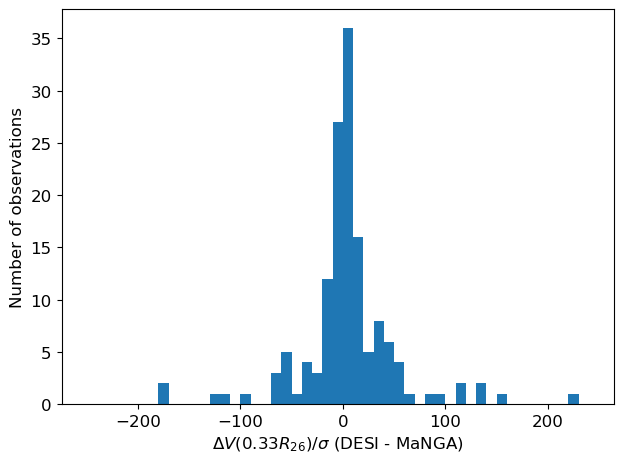

In [98]:
plt.figure(tight_layout=True)

plt.hist((VI_axis_0p3_good['V_ROT'] - VI_axis_0p3_good['V_ROT_MaNGA'])/np.sqrt(VI_axis_0p3_good['V_ROT_ERR']**2 + VI_axis_0p3_good['V_ROT_MaNGA_ERR']**2), 
         #bins=np.arange(-400, 100, 50), 
         bins=np.arange(-250, 250, 10)
        )

#plt.xlabel('$\Delta V(0.33R_{26})$ [km/s] (DESI - MaNGA fit)')
plt.xlabel('$\Delta V(0.33R_{26})/\sigma$ (DESI - MaNGA)')
plt.ylabel('Number of observations');

In [99]:
VI_axis_0p3_good.sort('V_ROT_MaNGA')
VI_axis_0p3_good['SGA_ID', 'V_ROT', 'V_MaNGA', 'V_ROT_MaNGA'][np.isfinite(VI_axis_0p3_good['V_ROT_MaNGA'])]

SGA_ID,V_ROT,V_MaNGA,V_ROT_MaNGA
int64,float64,float64,float64
378180,42.97648642281879,-795.5707397460938,-1094.714456564478
1387126,144.78736942799435,-155.8709259033203,-745.2976333298813
1387126,-41.173394737444426,-155.8709259033203,-745.2976333298813
1387991,138.45740695520482,-473.7549133300781,-486.4938816927659
1014365,206.0851390402495,-35.02645492553711,-469.67106474988725
841705,161.9593400838852,-410.80224609375,-406.8911960189038
841705,71.1901091723875,-410.80224609375,-406.8911960189038
573264,32.21352295457345,-140.13232421875,-334.25795599989226
1020852,-112.34066616778848,-221.72886657714844,-317.10537663099177


        RA                DEC        
------------------ ------------------
194.34570307697015 26.987876018094845
8932 12705


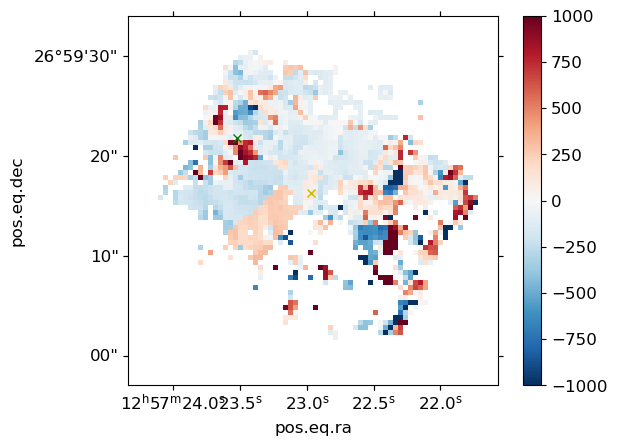

In [101]:
sga_gal = 629860

gal_row = SGA_MaNGA['SGA_ID'] == sga_gal
obs_idx = VI_axis_0p3_good['SGA_ID'] == sga_gal
center_idx = good_centers['SGA_ID'] == sga_gal
print(good_centers['RA', 'DEC'][center_idx])

gal_plate = SGA_MaNGA['plate'][gal_row][0]
gal_IFU = SGA_MaNGA['ifudsgn'][gal_row][0]
print(gal_plate, gal_IFU)

file_name = str(gal_plate) + '/' + str(gal_IFU) + '/manga-' + str(gal_plate) + '-' + str(gal_IFU) + '-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz'

hdul = fits.open(VEL_MAP_FOLDER + file_name)
vel = hdul['EMLINE_GVEL']
Ha_vel = vel.data[map_idx]
Ha_ivar = hdul['EMLINE_GVEL_IVAR'].data[map_idx]
Ha_mask = hdul['EMLINE_GVEL_MASK'].data[map_idx]

mHa_vel = ma.array(Ha_vel, mask=Ha_mask)
mHa_ivar = ma.array(Ha_ivar, mask=Ha_mask)

gal_wcs = wcs.WCS(vel.header)

plt.figure()
ax = plt.subplot(projection=gal_wcs, slices=('x', 'y', map_idx))
vel_im = ax.imshow(mHa_vel, cmap='RdBu_r', origin='lower', vmin=-1000, vmax=1000)
plt.plot(VI_axis_0p3_good['RA'][obs_idx], 
         VI_axis_0p3_good['DEC'][obs_idx], 
         'gx', 
         transform=ax.get_transform('world'))
plt.plot(good_centers['RA'][center_idx], 
         good_centers['DEC'][center_idx], 
         'yx', 
         transform=ax.get_transform('world'))
plt.colorbar(vel_im, ax=ax);